# Machine Learning
-----
By Maryah Garner

In this notebook, we'll discuss how to formulate a research question in the machine learning framework; how to build, evaluate, compare, and select models; and how to reasonably and accurately interpret model results. You'll also get hands-on experience using the `scikit-learn` package in Python.

This tutorial is based on chapter 6 of [Big Data and Social Science](https://github.com/BigDataSocialScience/).

## Glossary of Terms

There are a number of terms specific to Machine Learning that you will find repeatedly in this notebook. 
- **Features**: These are what you probably know as *independent variables*, *attributes*, *predictors*, 
or *explanatory variables.*
- **Underfitting**: This happens when a model is too simple and does not capture the structure of the data well 
enough.
- **Overfitting**: This happens when a model is too complex or too sensitive to the noise in the data; this can
result in poor generalization performance, or applicability of the model to new data. 
- **Regularization**: This is a general method to avoid overfitting by applying additional constraints to the model. 
For example, you can limit the number of features present in the final model, or the weight coefficients applied
to the (standardized) features are small.
- **Supervised learning** involves problems with one target or outcome variable (continuous or discrete) that we want
to predict, or classify data into. Classification, prediction, and regression fall into this category. We call the
set of explanatory variables $X$ **features**, and the outcome variable of interest $Y$ the **label**.


## Setup
We'll be using [`scikit-learn`](http://scikit-learn.org) for the machine learning models.

In [1]:
%pylab inline
import os
import glob
import pandas as pd
import time
import sklearn
import seaborn as sns
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## The Machine Learning Process

The Machine Learning Process is as follows:

- **Understand the problem and goal.** *This sounds obvious but is often nontrivial.* Problems typically start as vague descriptions of a goal - improving health outcomes, increasing graduation rates, understanding the effect of a variable *X* on an outcome *Y*, etc. It is really important to work with people who understand the domain being studied to dig deeper and define the problem more concretely. What is the analytical formulation of the metric that you are trying to optimize?
- **Formulate it as a machine learning problem.** Is it a classification problem or a regression problem? Is the goal to build a model that generates a ranked list prioritized by risk, or is it to detect anomalies as new data come in? Knowing what kinds of tasks machine learning can solve will allow you to map the problem you are working on to one or more machine learning settings and give you access to a suite of methods.
- **Data exploration and preparation.** Next, you need to carefully explore the data you have. What additional data do you need or have access to? What variable will you use to match records for integrating different data sources?  What variables exist in the data set? Are they continuous or categorical? What about missing values? Can you use the variables in their original form, or do you need to alter them in some way?
- **Feature engineering.** In machine learning language, what you might know as independent variables or predictors or factors or covariates are called "features." Creating good features is probably the most important step in the machine learning process. This involves doing transformations, creating interaction terms, or aggregating over data points or over time and space.
- **Method selection.** Having formulated the problem and created your features, you now have a suite of methods to choose from. It would be great if there were a single method that always worked best for a specific type of problem. Typically, in machine learning, you take a variety of methods and try them, empirically validating which one is the best approach to your problem.
- **Evaluation.** As you build a large number of possible models, you need a way choose the best among them. We'll cover methodology to validate models on historical data and discuss a variety of evaluation metrics. 
- **Deployment.** Once you have selected the best model and validated it using historical data as well as a field trial, you are ready to put the model into practice. You still have to keep in mind that new data will be coming in, and the model might change over time.

You're probably used to fitting models in social science classes. In those cases, you probably had a hypothesis or theory about the underlying process that gave rise to your data, chose an appropriate model based on prior knowledge and fit it using least squares, and used the resulting parameter or coefficient estimates (or confidence intervals) for inference. This type of modeling is very useful for *interpretation*.

In machine learning, our primary concern is *generalization*. This means that:
- **We care less about the structure of the model and more about the performance** This means that we'll try out a whole bunch of models at a time and choose the one that works best, rather than determining which model to use ahead of time. We can then choose to select a *suboptimal* model if we care about a specific model type. 
- **We don't (necessarily) want the model that best fits the data we've *already seen*,** but rather the model that will perform the best on *new data*. This means that we won't gauge our model's performance using the same data that we used to fit the model (e.g., sum of squared errors or $R^2$), and that "best fit" or accuracy will most often *not* determine the best model.  
- **We can include a lot of variables in to the model.** This may sound like the complete opposite of what you've heard in the past, and it can be hard to swallow. 

# Problem Formulation

First, turning something into a real objective function. What do you care about? Do you have data on that thing? What action can you take based on your findings? Do you risk introducing any bias based on the way you model something? 

### Four Main Types of ML Tasks for Policy Problems

- **Description**: [How can we identify and respond to the most urgent online government petitions?](https://dssg.uchicago.edu/project/improving-government-response-to-citizen-requests-online/)
- **Prediction**: [Which students will struggle academically by third grade?](https://dssg.uchicago.edu/project/predicting-students-that-will-struggle-academically-by-third-grade/)
- **Detection**: [Which police officers are likely to have an adverse interaction with the public?](https://dssg.uchicago.edu/project/expanding-our-early-intervention-system-for-adverse-police-interactions/)
- **Behavior Change**: [How can we prevent juveniles from interacting with the criminal justice system?](https://dssg.uchicago.edu/project/preventing-juvenile-interactions-with-the-criminal-justice-system/)
  
## Our Machine Learning Problems
In this notebook we will build a model to predict what PIs who work on NCI projects in 2014 will begin a new project researchering Brain cancer after the Cancer moonshot initiative.

## Data Exploration and Preparation

During the first classes, we have explored the data, linked different data sources, and created new variables. The first steps of creating a machine learning model are exactly that. 

1. **Creating the label**: The Lable is the dependent variable, or *Y* variable, that we are trying to predict. In the machine learning framework, labels are often *binary*: true or false, encoded as 1 or 0. 

1. **Decide on features**: Our features are our independent variables or predictors. Good features make machine learning systems effective. The better the features the easier it is the capture the structure of the data. You generate features using domain knowledge. In general, it is better to have more complex features and a simpler model rather than vice versa. Keeping the model simple makes it faster to train and easier to understand rather then extensively searching for the "right" model and "right" set of parameters. Machine Learning Algorithms learn a solution to a problem from sample data. The set of features is the best representation of the sample data to learn a solution to a problem.

1. **Feature engineering** is the process of transforming raw data into features that better represent the underlying problem/data/structure  to the predictive models, resulting in improved model accuracy on unseen data." ( from [Discover Feature Engineering](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/) ). Example of feature engineering are: 
    - **Transformations**, such a log, square, and square root.
    - **Dummy (binary) variables**, sometimes known as *indicator variables*, often done by taking categorical variables (such as industry) which do not have a numeric value, and adding them to models as a binary value.
    - **Aggregation.** Aggregate features often constitute the majority of features for a given problem. These use different aggregation functions (*count, min, max, average, standard deviation, etc.*) which summarize several values into one feature, aggregating over varying windows of time and space. For example, we may want to calculate the *number* (and *min, max, mean, variance*, etc.) of crimes within an *m*-mile radius of an address in the past *t* months for varying values of *m* and *t*, and then use all of them as features.

1. **Cleaning data**: To run the `scikit-learn` set of models your input dataset must have no missing variables.

1. **Imputing values to missing or irrelevant data**: Once the features are created, always check to make sure the values make sense. You might have some missing values, or impossible values for a given variable (negative values, major outliers). If you have missing values you should think hard about what makes the most sense for your problem; you may want to replace with `0`, the median or mean of your data, or some other value.

1. **Normalization**: Certain models will have an issue with features on different scales. For example, an individual's age is typically a number between 0 and 100 while earnings can be number between 0 and 1000000 (or higher). In order to circumvent this problem, we can scale our features to the same range (eg [0,1]).

###  Load the 2014 Data 

In [2]:
# Specify a path with the data folder
# Change "NAME" to your name as recorded on your computer
# path = 'C:/Users/NAME/PADM-GP_2505/Data/'
Path = '/Users/wsq/Desktop/Advanced Data Analytics and Evidence Building/PADM-GP_2505/Data'
# use the chdir funftion from the os package to sed your working directory 
os.chdir(Path + "/Projects")


In [3]:
# Read-in the 2014 projects file
grants_2014 = pd.read_csv(Path + '/Projects/RePORTER_PRJ_C_FY2014_new.csv', encoding='latin-1')

## Clean the PI IDs
Clean the PI IDs for 2014. We are going to clean the PI ID just like we cleaned the PI names in previous Notebooks. We will be using the PI ID instead of the Name, because it is a better way to identify a unique individual. We used the names in previous notbooks for pedagogical purposes, becuase it is more intuative. 

In [4]:
grants_2014 = grants_2014.reset_index()

# First we need to convert PI_IDS into a string variable
grants_2014['PI_IDS'] = grants_2014['PI_IDS'].astype(str)

# Make a temperary dataframe that creates an observation for each PI. 
# Use the explode function to split the PI_IDS at the ;
temp = grants_2014['PI_IDS'].str.split(';').explode().reset_index()

# Rename the PI_IDS variable
temp = temp.rename(columns = {'PI_IDS': 'PI_ID'})

# Replace " " with and emplty string
temp['PI_ID'] = temp['PI_ID'].str.replace(' ','')

# Only keep observations in the temp dataframe where PI_ID is not an empty string or a sting with a single space
temp = temp[temp['PI_ID'] !=""]
temp = temp[temp['PI_ID'] !=" "]
temp = temp[temp['PI_ID'] !="  "]

# For the the PI_ID variable, use the str.replace fundtion to replace ` (contact)` with nothing 
temp['PI_ID'] = temp['PI_ID'].str.replace('\(contact\)', '')

# Merge this temperary dataframe with df_NYU
grants_2014B = grants_2014.merge(temp, on = 'index')

# Filter for NCI prpjects
grants_2014B = grants_2014B[grants_2014B['IC_NAME'] == 'NATIONAL CANCER INSTITUTE']

# view the select variables for the firts 5 observations
grants_2014B[['APPLICATION_ID', 'PI_NAMEs', 'PI_ID','PI_IDS','FY','FULL_PROJECT_NUM', 'PROJECT_TITLE','PROJECT_START', 'PROJECT_END', 'TOTAL_COST']].head()


,APPLICATION_ID,PI_NAMEs,PI_ID,PI_IDS,FY,FULL_PROJECT_NUM,PROJECT_TITLE,PROJECT_START,PROJECT_END,TOTAL_COST
1,8715629,"BURDETTE, EVERETTE C (contact); DIEDERICH, CHR...",8495898,8495898 (contact); 1888559;,2014,2R44CA121740-02,Minimally Invasive High Intensity Ultrasound T...,2/1/2006,7/31/2016,647919.0
2,8715629,"BURDETTE, EVERETTE C (contact); DIEDERICH, CHR...",1888559,8495898 (contact); 1888559;,2014,2R44CA121740-02,Minimally Invasive High Intensity Ultrasound T...,2/1/2006,7/31/2016,647919.0
3,8676705,"BICKELL, NINA A;",3150322,3150322;,2014,5R01CA149025-05,Implementing a Tracking & Feedback Registry to...,8/1/2010,5/31/2016,584428.0
17,8616355,"TUSCHL, THOMAS ;",7337985,7337985;,2014,5R01CA159227-04,Development of quantitative multiplex RNA in s...,3/1/2011,2/29/2016,345751.0
19,8585032,"BESSLER, MONICA ;",3144163,3144163;,2014,5R01CA105312-09,MOLECULAR STUDIES OF BONE MARROW FAILURE,12/1/2003,8/31/2015,561426.0


# Creating Labels
Labels are the dependent variables, or Y variables, that we are trying to predict. In the machine learning framework, your labels are usually binary: true or false, encoded as 1 or 0. In this case, our label will identify all people who started working on a Brain Cancer project betewwn FY 2016 and FY 2020
- Note the cohort of people we are studying are all people who worked on NCI projects on 2014

### Read in the data
When reading in the data we will do several things
- **Create a loop that will read in project data from 2016-2020**
- **Select only the columns we need**
- **Filter for NCI projects**
- **Filter for having a spending catagory of Brain Cancer**
- **Convert PROJECT_START into a datetime variable**

In [5]:
# Identify the files you want to read in
years = ('RePORTER_PRJ_C_FY2016_new.csv', 'RePORTER_PRJ_C_FY2017_new.csv', 'RePORTER_PRJ_C_FY2018_new.csv', 'RePORTER_PRJ_C_FY2019_new.csv', 'RePORTER_PRJ_C_FY2020_new.csv')

In [6]:
# Generate an empty dataframe that will hold all the patent data we have
NCI_2016_2020 = pd.DataFrame([])

# Now loop through each file identified in the years vector
# Read that file using only the columns we need
# And append it to the dataframe that we created above
# This might take a little while to run (no more than 1 minute)
for counter, file in enumerate(years):
    print(counter,file)
    projects = pd.read_csv(file, usecols=['APPLICATION_ID','FY', 'IC_NAME', 'PI_IDS','PROJECT_START', 'NIH_SPENDING_CATS'], 
                           encoding='latin-1')
     # Filter for NCI prpjects
    projects = projects[projects['IC_NAME'] == 'NATIONAL CANCER INSTITUTE']
    # Select Brain Cancer NCI projects 
    projects = projects[projects['NIH_SPENDING_CATS'].str.contains('Brain Cancer', na = False)]
    
    # convert PROJECT_START into a date variable
    projects['PROJECT_START'] = pd.to_datetime(projects['PROJECT_START'])

    NCI_2016_2020 = NCI_2016_2020.append(projects)
    
NCI_2016_2020 = NCI_2016_2020.reset_index(drop=True)
NCI_2016_2020.head(20)

0 RePORTER_PRJ_C_FY2016_new.csv
1 RePORTER_PRJ_C_FY2017_new.csv
2 RePORTER_PRJ_C_FY2018_new.csv
3 RePORTER_PRJ_C_FY2019_new.csv
4 RePORTER_PRJ_C_FY2020_new.csv


,APPLICATION_ID,FY,IC_NAME,NIH_SPENDING_CATS,PI_IDS,PROJECT_START
0,9344016,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Neurosc...,11142396;,NaT
1,9067335,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Genetic...,1870316;,2015-05-15
2,9149712,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Clinica...,9076342;,NaT
3,9338858,2016,NATIONAL CANCER INSTITUTE,Aging; Brain Cancer; Brain Disorders; Breast C...,9294195; 1888652; 1873940 (contact);,2014-04-17
4,9128413,2016,NATIONAL CANCER INSTITUTE,Bioengineering; Brain Cancer; Brain Disorders;...,10363645;,2014-09-01
5,9130563,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Clinica...,2446782;,NaT
6,9112879,2016,NATIONAL CANCER INSTITUTE,Autoimmune Disease; Biotechnology; Brain Cance...,3160894;,NaT
7,9049804,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Neurosc...,11021607;,2016-03-01
8,9091475,2016,NATIONAL CANCER INSTITUTE,Bioengineering; Brain Cancer; Brain Disorders;...,6981660; 1878504; 1967798; 1874950 (contact); ...,2013-08-06
9,9303103,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Clinica...,6824984;,1997-04-01


### Clean the PI IDs

In [7]:
# First we need to convert PI_IDS into a string variable
NCI_2016_2020['PI_IDS'] = NCI_2016_2020['PI_IDS'].astype(str)

# Make a temperary dataframe that creates an observation for each PI. 
# Use the explode function to split the PI_IDS at the ;
temp = NCI_2016_2020['PI_IDS'].str.split(';').explode().reset_index()

# Rename the PI_IDS variable
temp = temp.rename(columns = {'PI_IDS': 'PI_ID'})

# Replace " " with and emplty string
temp['PI_ID'] = temp['PI_ID'].str.replace(' ','')


# Only keep observations in the temp dataframe where PI_ID is not an empty string or a sting with a single space
temp = temp[temp['PI_ID'] !=""]
temp = temp[temp['PI_ID'] !=" "]

# For the the PI_ID variable, use the str.replace fundtion to replace ` (contact)` with nothing 
temp['PI_ID'] = temp['PI_ID'].str.replace('\(contact\)', '')

temp.head()

,index,PI_ID
0,0,11142396
2,1,1870316
4,2,9076342
6,3,9294195
7,3,1888652


In [8]:
# reset the index
NCI_2016_2020 = NCI_2016_2020.reset_index()

# view the firts 5 observations
NCI_2016_2020.head()

,index,APPLICATION_ID,FY,IC_NAME,NIH_SPENDING_CATS,PI_IDS,PROJECT_START
0,0,9344016,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Neurosc...,11142396;,NaT
1,1,9067335,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Genetic...,1870316;,2015-05-15
2,2,9149712,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Clinica...,9076342;,NaT
3,3,9338858,2016,NATIONAL CANCER INSTITUTE,Aging; Brain Cancer; Brain Disorders; Breast C...,9294195; 1888652; 1873940 (contact);,2014-04-17
4,4,9128413,2016,NATIONAL CANCER INSTITUTE,Bioengineering; Brain Cancer; Brain Disorders;...,10363645;,2014-09-01


In [9]:
# Merge this temperary dataframe with grants_2017
NCI_2016_2020B = NCI_2016_2020.merge(temp, on = 'index')

# view the firts 5 observations
NCI_2016_2020B.head(10)

,index,APPLICATION_ID,FY,IC_NAME,NIH_SPENDING_CATS,PI_IDS,PROJECT_START,PI_ID
0,0,9344016,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Neurosc...,11142396;,NaT,11142396
1,1,9067335,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Genetic...,1870316;,2015-05-15,1870316
2,2,9149712,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Clinica...,9076342;,NaT,9076342
3,3,9338858,2016,NATIONAL CANCER INSTITUTE,Aging; Brain Cancer; Brain Disorders; Breast C...,9294195; 1888652; 1873940 (contact);,2014-04-17,9294195
4,3,9338858,2016,NATIONAL CANCER INSTITUTE,Aging; Brain Cancer; Brain Disorders; Breast C...,9294195; 1888652; 1873940 (contact);,2014-04-17,1888652
5,3,9338858,2016,NATIONAL CANCER INSTITUTE,Aging; Brain Cancer; Brain Disorders; Breast C...,9294195; 1888652; 1873940 (contact);,2014-04-17,1873940
6,4,9128413,2016,NATIONAL CANCER INSTITUTE,Bioengineering; Brain Cancer; Brain Disorders;...,10363645;,2014-09-01,10363645
7,5,9130563,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Clinica...,2446782;,NaT,2446782
8,6,9112879,2016,NATIONAL CANCER INSTITUTE,Autoimmune Disease; Biotechnology; Brain Cance...,3160894;,NaT,3160894
9,7,9049804,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Neurosc...,11021607;,2016-03-01,11021607


### Filter for new projects
We want to identify all PIs that had a Brain Cancer project start after the 2016 fiscal year began

In [10]:
# Define the start as the pridr day in Fiscal year 2016
State_date = pd.to_datetime('10/01/2015')

# select all nre procjects (that started after FY 2016)
New_NCI_PI = NCI_2016_2020B[NCI_2016_2020B['PROJECT_START'] >= State_date]

# Reset index
New_NCI_PI = New_NCI_PI.reset_index()

# view the firts 5 observations
New_NCI_PI.head()

,level_0,index,APPLICATION_ID,FY,IC_NAME,NIH_SPENDING_CATS,PI_IDS,PROJECT_START,PI_ID
0,9,7,9049804,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Neurosc...,11021607;,2016-03-01,11021607
1,17,11,9003765,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Genetic...,7075834;,2015-12-14,7075834
2,21,14,9029909,2016,NATIONAL CANCER INSTITUTE,Brain Cancer; Brain Disorders; Cancer; Genetic...,1893276;,2015-12-01,1893276
3,25,17,9210945,2016,NATIONAL CANCER INSTITUTE,Bioengineering; Biotechnology; Brain Cancer; B...,1965067 (contact); 1951886;,2016-09-14,1965067
4,26,17,9210945,2016,NATIONAL CANCER INSTITUTE,Bioengineering; Biotechnology; Brain Cancer; B...,1965067 (contact); 1951886;,2016-09-14,1951886


In [11]:
New_NCI_PI = New_NCI_PI[['PI_ID']].drop_duplicates()
New_NCI_PI["New_BC"] = 1

# view the select variables for the firts 4 observations
New_NCI_PI.head(8)

,PI_ID,New_BC
0,11021607,1
1,7075834,1
2,1893276,1
3,1965067,1
4,1951886,1
5,11951932,1
6,11873857,1
7,14271813,1


### Join the data
We will create a new dataframe by joining the grants_2014B and New_NCI_PI dataframes. We will continue using this data frame to stor all the features we create.

In [12]:
# Merge the temp dataframe into the DF_2015 data frame 
# Use an left merge
# keep only the PI_ID and NCI_2017 variables and then drop duplicates. This will give us one observation per person
DF = pd.merge(grants_2014B, New_NCI_PI, on='PI_ID', how = 'left')[['PI_ID','New_BC']].drop_duplicates()
DF.head()

,PI_ID,New_BC
0,8495898,NaN
1,1888559,NaN
2,3150322,NaN
3,7337985,NaN
4,3144163,NaN


The observations that have an Nan for NCI_2017, means they did not have a new NCI project in 2017, so we will replace that NaN value with a 0

In [13]:
DF['New_BC'] = DF['New_BC'].fillna(0)

DF.head()

,PI_ID,New_BC
0,8495898,0.0
1,1888559,0.0
2,3150322,0.0
3,7337985,0.0
4,3144163,0.0


In [14]:
DF.shape

(7741, 2)

In [15]:
sum(DF['New_BC'])

195.0

There are 7741 PIs who had NCI project in 2017, of whom 2750 started a new Brain Cancer NCI project between 2016-2020

# Feature Generation
Our features are our independent variables or predictors. Good features make machine learning systems effective. The better the features the easier it is the capture the structure of the data. You generate features using domain knowledge. In general, it is better to have more complex features and a simpler model rather than vice versa. Keeping the model simple makes it faster to train and easier to understand rather then extensively searching for the "right" model and "right" set of parameters.

Our features are the following
- NIH_SPENDING_CATS: We need to identify each spending cataory each PI has grants in then make dummies
- State: The state in which the applicant organization is located (we need to make dummies)
- Number of NCI projects in 2014
- Number of projects that will still be active in 2016, 2017, 2018, 2019, and 2020
- Total Cost of 2014 Projects
- brain cancer activity of organizations (creating binary variables for different levels of activity)

### Spending Catagory

In [16]:
grants_2014B[['NIH_SPENDING_CATS']].head()

,NIH_SPENDING_CATS
1,Bioengineering; Cancer; Contraception/Reproduc...
2,Bioengineering; Cancer; Contraception/Reproduc...
3,Breast Cancer; Cancer; Clinical Research; Clin...
17,Biotechnology; Cancer; Clinical Research; Gene...
19,Cancer; Clinical Research; Genetics; Hematolog...


#### Seperate up the Spending Catagory

In [17]:
# First we need to convert PI_IDS into a string variable
grants_2014B['PI_IDS'] = grants_2014B['NIH_SPENDING_CATS'].astype(str)

# Make a temporary dataframe that creates an observation for each spending catagory
# Use the explode function to split the NIH_SPENDING_CATS at the ;
temp = grants_2014B['NIH_SPENDING_CATS'].str.split(';').explode().reset_index()

# Rename the NIH_SPENDING_CATS variable
temp = temp.rename(columns = {'NIH_SPENDING_CATS': 'NIH_SPENDING_CAT'})

# Replace " " with and emplty string
temp['NIH_SPENDING_CAT'] = temp['NIH_SPENDING_CAT'].str.replace(' ','')


# Only keep observations in the temp dataframe where PI_ID is not an empty string
temp = temp[temp['NIH_SPENDING_CAT'] !=""]

temp.head(10)

,index,NIH_SPENDING_CAT
0,1,Bioengineering
1,1,Cancer
2,1,Contraception/Reproduction
3,1,DiagnosticRadiology
4,1,FibroidTumors(Uterine)
6,2,Bioengineering
7,2,Cancer
8,2,Contraception/Reproduction
9,2,DiagnosticRadiology
10,2,FibroidTumors(Uterine)


In [18]:
# Select the relavent columns 
Cat = grants_2014B[['index', 'PI_ID', 'NIH_SPENDING_CATS']]

Cat.head()

,index,PI_ID,NIH_SPENDING_CATS
1,1,8495898,Bioengineering; Cancer; Contraception/Reproduc...
2,1,1888559,Bioengineering; Cancer; Contraception/Reproduc...
3,2,3150322,Breast Cancer; Cancer; Clinical Research; Clin...
17,13,7337985,Biotechnology; Cancer; Clinical Research; Gene...
19,15,3144163,Cancer; Clinical Research; Genetics; Hematolog...


In [19]:
# Merge this temporary dataframe with the spending catagory dataframe
Cat2 = Cat.merge(temp, on = 'index')

# Remove the index and NIH_SPENDING_CATS variables
Cat2 = Cat2.drop(columns=['index', 'NIH_SPENDING_CATS'])

# Drop duplicate observations
Cat2 = Cat2.drop_duplicates()

# Drop duplicate observations
Cat2['Cat'] = 1

# View the first 10 observations
Cat2.head(10)


,PI_ID,NIH_SPENDING_CAT,Cat
0,8495898,Bioengineering,1
1,8495898,Cancer,1
2,8495898,Contraception/Reproduction,1
3,8495898,DiagnosticRadiology,1
4,8495898,FibroidTumors(Uterine),1
5,1888559,Bioengineering,1
6,1888559,Cancer,1
7,1888559,Contraception/Reproduction,1
8,1888559,DiagnosticRadiology,1
9,1888559,FibroidTumors(Uterine),1


#### Create Dummy variables for each of the spending catagories
To create these Dummy variables, we will transform the dataframe from long to wide

In [20]:
# use the pivot function to transform the dataframe from long to wide
Cat3 = pd.pivot(Cat2, index='PI_ID', columns = 'NIH_SPENDING_CAT',values = 'Cat')

#Re-arange the new columns in the correct order
cols = Cat2['NIH_SPENDING_CAT'].unique()
Cat3=Cat3[cols]

# Replace missing values with 0
Cat3 = Cat3.fillna(0)

# View the first 5 observations
Cat3.head()

NIH_SPENDING_CAT,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,BreastCancer,ClinicalResearch,...,Crohn'sDisease,InflammatoryBowelDisease,DigestiveDiseases-(Gallbladder),Asthma,ChronicObstructivePulmonaryDisease,StemCellResearch-UmbilicalCordBlood/Placenta-Human,Hepatitis-C,GeneTherapyClinicalTrials,Arthritis,Infertility
PI_ID,,,,,,,,,,,,,,,,,,,,,
10012000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10021262,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10021476,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10108300,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10113370,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Join the data
Join the features we just created with the DF fataframe

In [21]:
# Join Cat3 with the DF fataframe using a left join
DF = pd.merge(DF, Cat3, on = 'PI_ID',  how = 'left')

# View the first 5 observations
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,Crohn'sDisease,InflammatoryBowelDisease,DigestiveDiseases-(Gallbladder),Asthma,ChronicObstructivePulmonaryDisease,StemCellResearch-UmbilicalCordBlood/Placenta-Human,Hepatitis-C,GeneTherapyClinicalTrials,Arthritis,Infertility
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### State
We will create dunny variables for state

In [22]:
state = grants_2014B[['PI_ID', 'ORG_STATE']]

# Drop duplicate observations
state = state.drop_duplicates()

# Only keep the first state reccorded for each PI
state = state.groupby(['PI_ID']).first()

# View the first 5 observations
state.head()

,ORG_STATE
PI_ID,
10000506,None
10011128,AZ
10012000,MA
10021262,ON
10021476,NY


In [23]:
# We need to creat dummy variables for state and organization name
state2 = pd.get_dummies(state, columns=['ORG_STATE'])

state2.head()

,ORG_STATE_AK,ORG_STATE_AL,ORG_STATE_AR,ORG_STATE_AZ,ORG_STATE_BC,ORG_STATE_CA,ORG_STATE_CO,ORG_STATE_CT,ORG_STATE_DC,ORG_STATE_DE,...,ORG_STATE_SC,ORG_STATE_SD,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV
PI_ID,,,,,,,,,,,,,,,,,,,,,
10000506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10011128,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10012000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10021262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10021476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are a few states PIs that are with orginizations from different states, we have to identify them and then collaps the Sate dummy variable for them

In [24]:
state2.shape

(7741, 53)

# Check point 1
I wanted to provide code to make simple dummy variables, however, to do this for the state data, we needed to select a single state for each person. It is better to identify every ORG_STATE a person is associated with in 2014. Using the long to wide transfer we did when creating the dummy variables for spending catagories, create state dummy variables that identify every ORG_STATE a person is associated with. You should write over the state2 data frame so that the code to join the DF data with the states data runs. (1 points)

In [25]:
# Select the relavant columns
State_temp = grants_2014B[['index','PI_ID', 'ORG_STATE']]
State_temp.head()

,index,PI_ID,ORG_STATE
1,1,8495898,IL
2,1,1888559,IL
3,2,3150322,NY
17,13,7337985,NY
19,15,3144163,PA


In [26]:
# Merge this temporary dataframe with the spending catagory dataframe
State_temp2 = State_temp.merge(temp, on = 'index')

# Remove the index and NIH_SPENDING_CATS variables
State_temp2 = State_temp2.drop(columns=['index','NIH_SPENDING_CAT'])

# Drop duplicate observations
State_temp2 = State_temp2.drop_duplicates()

# Drop duplicate observations
State_temp2['State_temp'] = 1

# View the first 10 observations
State_temp2.head(10)

,PI_ID,ORG_STATE,State_temp
0,8495898,IL,1
5,1888559,IL,1
10,3150322,NY,1
15,6265424,NY,1
19,12448156,NaN,1
23,1869066,HI,1
27,12430520,CA,1
34,8590003,TN,1
36,1877317,TN,1
38,7284983,WA,1


In [27]:
# use the pivot function to transform the dataframe from long to wide
State_temp3 = pd.pivot(State_temp2, index='PI_ID', columns = 'ORG_STATE',values = 'State_temp')

#Re-arange the new columns in the correct order
cols = State_temp2['ORG_STATE'].unique()
State_temp3=State_temp3[cols]

# Replace missing values with 0
State_temp3 = State_temp3.fillna(0)

# View the first 5 observations
State_temp3.head()

ORG_STATE,IL,NY,NaN,HI,CA,TN,WA,MA,KS,OR,...,VT,MS,QC,LA,SD,PR,NV,DE,OK,ON
PI_ID,,,,,,,,,,,,,,,,,,,,,
10012000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10021262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10021476,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10108300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10113370,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Join Cat3 with the DF fataframe using a left join
DF = pd.merge(DF, State_temp3, on = 'PI_ID',  how = 'left')

# View the first 5 observations
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,VT,MS,QC,LA,SD,PR,NV,DE,OK,ON
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# We need to creat dummy variables for state and organization name
state2 = pd.get_dummies(state, columns=['ORG_STATE'])

state2.head()

,ORG_STATE_AK,ORG_STATE_AL,ORG_STATE_AR,ORG_STATE_AZ,ORG_STATE_BC,ORG_STATE_CA,ORG_STATE_CO,ORG_STATE_CT,ORG_STATE_DC,ORG_STATE_DE,...,ORG_STATE_SC,ORG_STATE_SD,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV
PI_ID,,,,,,,,,,,,,,,,,,,,,
10000506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10011128,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10012000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10021262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10021476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
state2.shape

(7741, 53)

#### Join the DF data with the States data 

In [31]:
# Merge this temporary dataframe with the spending catagory dataframe
State_temp2 = State_temp.merge(temp, on = 'index')

# Remove the index and NIH_SPENDING_CATS variables
#State_temp2 = State_temp2.drop(columns=['index', 'ORG_STATE'])

# Drop duplicate observations
State_temp2 = State_temp2.drop_duplicates()

# Drop duplicate observations
State_temp2['State_temp'] = 1

# View the first 10 observations
State_temp2.head(10)

,index,PI_ID,ORG_STATE,NIH_SPENDING_CAT,State_temp
0,1,8495898,IL,Bioengineering,1
1,1,8495898,IL,Cancer,1
2,1,8495898,IL,Contraception/Reproduction,1
3,1,8495898,IL,DiagnosticRadiology,1
4,1,8495898,IL,FibroidTumors(Uterine),1
5,1,1888559,IL,Bioengineering,1
6,1,1888559,IL,Cancer,1
7,1,1888559,IL,Contraception/Reproduction,1
8,1,1888559,IL,DiagnosticRadiology,1
9,1,1888559,IL,FibroidTumors(Uterine),1


In [32]:
# use a left join nerge to join the state2 data witht the DF dataframe
DF = pd.merge(DF, state2, on = 'PI_ID',  how = 'left')

# View the first 5 observations
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_SC,ORG_STATE_SD,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


### Number of projects in 2014

In [33]:
# Calculate how many Projects each PI has
projects = grants_2014B.groupby(['PI_ID'])['APPLICATION_ID'].nunique().sort_values(ascending=False)

# Convert into a dataframe and reset index
projects = projects.to_frame().reset_index()

# Rename APPLICATION_ID to Total_NCI_Projects_2014
projects.rename(columns={'APPLICATION_ID':'Total_NCI_Projects_2014'}, inplace = True)

# View the first 2 observations 
projects.head(2)

,PI_ID,Total_NCI_Projects_2014
0,14267998,58
1,1875698,40


#### Join the DF data with the projects data 

In [34]:
DF = pd.merge(DF, projects, on = 'PI_ID',  how = 'inner')

# View the first 5 observations
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_SD,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,6
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1


### Number of projects what will still be active in  FY 2016

In [35]:
# convert PROJECT_END into a date variable
grants_2014B['PROJECT_END'] = pd.to_datetime(grants_2014['PROJECT_END'])

In [36]:
# Idenfity the end of FY 2015
FY_2016 = pd.to_datetime('09/30/2015')

# Filter for projects that will still me active in 2016
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2016]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2016' that is equal to one for all observations
ongoing['active_2016'] = 1

# View the first 2 observations 
ongoing.head(2)

,PI_ID,active_2016
1,8495898,1
2,1888559,1


In [37]:
# Sum up the number of projects that will still be active in 2016 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2016'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# View the first 2 observations 
ongoing.head(2)

,PI_ID,active_2016
0,10000506,1
1,10011128,1


In [38]:
# convert PROJECT_END into a date variable
grants_2014B['PROJECT_END'] = pd.to_datetime(grants_2014['PROJECT_END'])

In [39]:
# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2017 with 0
DF['active_2016'] = DF['active_2016'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,2,1.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,6,3.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,1.0


### Number of projects what will still be active in FY 2017

In [40]:
# Idenfity the end of FY 2016
FY_2017 = pd.to_datetime('09/30/2016')

# Filter for projects that will still me active in 2017
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2017]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2017' that is equal to one for all observations
ongoing['active_2017'] = 1

# Sum up the number of projects that will still be active in 2017 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2017'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2017 with 0
DF['active_2017'] = DF['active_2017'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2,1.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,6,3.0,2.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,1.0,0.0


### Number of projects what will still be active in FY 2018

In [41]:
# Idenfity the end of FY 2017
FY_2018 = pd.to_datetime('09/30/2017')

# Filter for projects that will still me active in 2016
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2018]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2018' that is equal to one for all observations
ongoing['active_2018'] = 1

# Sum up the number of projects that will still be active in 2018 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2018'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2018 with 0
DF['active_2018'] = DF['active_2018'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,2,1.0,0.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,6,3.0,2.0,0.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,1.0,0.0,0.0


### Number of projects what will still be active in FY 2019

In [42]:
# Idenfity the end of FY 2018
FY_2019 = pd.to_datetime('09/30/2018')

# Filter for projects that will still me active in 2019
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2019]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2019' that is equal to one for all observations
ongoing['active_2019'] = 1

# Sum up the number of projects that will still be active in 2019 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2019'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2019 with 0
DF['active_2019'] = DF['active_2019'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,2,1.0,0.0,0.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,6,3.0,2.0,0.0,0.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0


### Number of projects what will still be active in FY 2020

In [43]:
# Idenfity the end of FY 2019
FY_2020 = pd.to_datetime('09/30/2019')

# Filter for projects that will still me active in 2020
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2020]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2020' that is equal to one for all observations
ongoing['active_2020'] = 1

# Sum up the number of projects that will still be active in 2020 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2020'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2020 with 0
DF['active_2020'] = DF['active_2020'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,2,1.0,0.0,0.0,0.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,6,3.0,2.0,0.0,0.0,0.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0


### Total Cost of Projects

In [44]:
# Calculate how many Projects each PI has
Cost = grants_2014B.groupby(['PI_ID'])['TOTAL_COST'].sum()

# Convert into a dataframe and reset index
Cost = Cost.to_frame().reset_index()

# drop first row
Cost = Cost.iloc[1:, :]

# View the first 5 observations 
Cost.head()

,PI_ID,TOTAL_COST
1,10011128,750566.0
2,10012000,85785.0
3,10021262,217377.0
4,10021476,278247.0
5,10027192,310470.0


In [45]:
DF = pd.merge(DF, Cost, on = 'PI_ID',  how = 'left')
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,647919.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,647919.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,2,1.0,0.0,0.0,0.0,0.0,584429.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,6,3.0,2.0,0.0,0.0,0.0,1765884.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,561426.0


### Number of NCI projcts by orginization 

In [46]:
# Use a conditional statement do create a new dataframe were there are only projects where the IC_NAME is NATIONAL CANCER INSTITUTE. 
BC = grants_2014B[grants_2014B['NIH_SPENDING_CATS'].str.contains('Brain Cancer', na = False)]
    
# Calculate how many NCI Projects each ORG has
BC = BC.groupby(['ORG_NAME'])['APPLICATION_ID'].nunique().sort_values(ascending=False)

# Convert into a dataframe and reset index
BC = BC.to_frame().reset_index()

# Rename APPLICATION_ID to Total_BC_Projects_by_ORG
BC.rename(columns={'APPLICATION_ID':'Total_BC_Projects_by_ORG'}, inplace = True)

# View the first 5 observations 
BC.head()


,ORG_NAME,Total_BC_Projects_by_ORG
0,"UNIVERSITY OF CALIFORNIA, SAN FRANCISCO",49
1,BASIC SCIENCES,44
2,MASSACHUSETTS GENERAL HOSPITAL,33
3,DUKE UNIVERSITY,24
4,UNIVERSITY OF TX MD ANDERSON CAN CTR,21


In [47]:
BC2 = pd.merge(grants_2014B, BC, on = 'ORG_NAME',  how = 'left')[[ 'PI_ID', 'Total_BC_Projects_by_ORG', 'ORG_NAME']]

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
BC2['Total_BC_Projects_by_ORG'] = BC2['Total_BC_Projects_by_ORG'].fillna(0)

#Drop duplicate observations
BC2 = BC2.drop_duplicates()

# View the first 5 observations
BC2.head()

,PI_ID,Total_BC_Projects_by_ORG,ORG_NAME
0,8495898,0.0,"ACOUSTIC MEDSYSTEMS, INC."
1,1888559,0.0,"ACOUSTIC MEDSYSTEMS, INC."
2,3150322,3.0,ICAHN SCHOOL OF MEDICINE AT MOUNT SINAI
3,7337985,0.0,ROCKEFELLER UNIVERSITY
4,3144163,1.0,CHILDREN'S HOSP OF PHILADELPHIA


In [48]:
# Sum up the number of projects for people who worked for more than one org
BC3 = BC2.groupby(['PI_ID'])['Total_BC_Projects_by_ORG'].sum()

# Convert into a dataframe and reset index
BC3 = BC3.to_frame().reset_index()

# View the first 5 observations 
BC3.head()

,PI_ID,Total_BC_Projects_by_ORG
0,10000506,47.0
1,10011128,0.0
2,10012000,10.0
3,10021262,0.0
4,10021476,3.0


We will look at the distribution of the Total_BC_Projects_by_ORG variable to understand better how to split it up

In [49]:
# use the describe to look at the distribution
BC3['Total_BC_Projects_by_ORG'].describe()

count    7741.000000
mean        7.962796
std        12.097469
min         0.000000
25%         0.000000
50%         3.000000
75%         9.000000
max        76.000000
Name: Total_BC_Projects_by_ORG, dtype: float64

Looking at this distribution, we will break the organizations into the following groups: 
 - No brain cancer projects.
 - A few brain cancer projects (1-3)
 - A Moderate number of brain cancer projects (5-9)
 - Several brain cancer projects (10-20)
 - A large number of brain cancer projects (over 20)

#### No brain cancer projects

In [50]:
# Identify observations where the PI is from an org with no brain cancer projects
No = BC3[BC3['Total_BC_Projects_by_ORG'] == 0]

# Create a variable "Org_No" that is equal to 1
No['Org_No'] = 1

# Select the two variables we need
No = No[['PI_ID', 'Org_No']]

# Merge with the DF dataframe
DF = pd.merge(DF, No, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_No'] = DF['Org_No'].fillna(0)

# View the first 5 observations 
DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,2,1.0,0.0,0.0,0.0,0.0,584429.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,6,3.0,2.0,0.0,0.0,0.0,1765884.0,1.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,1.0,0.0,0.0,0.0,0.0,561426.0,0.0


#### A few brain cancer projects (1-3)

In [51]:
# Identify observations where the PI is from an org with 1-3 brain cancer projects
Few = BC3[BC3['Total_BC_Projects_by_ORG'] >= 1]
Few = Few[Few['Total_BC_Projects_by_ORG'] <= 3]

# Create a variable "Org_No" that is equal to 1
Few['Org_Few'] = 1

# Select the two variable we need
Few = Few[['PI_ID', 'Org_Few']]

# Merge with the DF dataframe
DF = pd.merge(DF, Few, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_Few'] = DF['Org_Few'].fillna(0)

DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,2,1.0,0.0,0.0,0.0,0.0,584429.0,0.0,1.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,3.0,2.0,0.0,0.0,0.0,1765884.0,1.0,0.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,1.0,0.0,0.0,0.0,0.0,561426.0,0.0,1.0


#### A Moderate number of brain cancer projects (5-9)

In [52]:
# Identify observations where the PI is from an org with 5-9 brain cancer projects
Moderate = BC3[BC3['Total_BC_Projects_by_ORG'] >= 5]
Moderate = Moderate[Moderate['Total_BC_Projects_by_ORG'] <= 9]

# Create a variable "Org_No" that is equal to 1
Moderate['Org_Mod'] = 1

# Select the two variables we need
Moderate = Moderate[['PI_ID', 'Org_Mod']]

# Merge with the DF dataframe
DF = pd.merge(DF, Moderate, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_Mod'] = DF['Org_Mod'].fillna(0)

DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2,1.0,0.0,0.0,0.0,0.0,584429.0,0.0,1.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,3.0,2.0,0.0,0.0,0.0,1765884.0,1.0,0.0,0.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.0,0.0,0.0,0.0,0.0,561426.0,0.0,1.0,0.0


#### Several brain cancer projects (10-15)

In [53]:
# Identify observations where the PI is from an org with 10-20 brain cancer projects
Several = BC3[BC3['Total_BC_Projects_by_ORG'] >= 10]
Several = Several[Several['Total_BC_Projects_by_ORG'] <= 20]

# Create a variable "Org_No" that is equal to 1
Several['Org_Several'] = 1

# Select the two variable we need
Several = Several[['PI_ID', 'Org_Several']]

# Merge with the DF dataframe
DF = pd.merge(DF, Several, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_Several'] = DF['Org_Several'].fillna(0)

DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,584429.0,0.0,1.0,0.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,0.0,0.0,0.0,1765884.0,1.0,0.0,0.0,0.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,561426.0,0.0,1.0,0.0,0.0


#### Large number of brain cancer projects (over 20)

In [54]:
# Identify observations where the PI is from an org with more than brain cancer projects
large = BC3[BC3['Total_BC_Projects_by_ORG'] > 20]

# Create a variable "Org_No" that is equal to 1
large['Org_large'] = 1

# Select the two variable we need
large = large[['PI_ID', 'Org_large']]

# Merge with the DF dataframe
DF = pd.merge(DF, large, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_large'] = DF['Org_large'].fillna(0)

DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several,Org_large
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,584429.0,0.0,1.0,0.0,0.0,0.0
3,7337985,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,0.0,0.0,0.0,1765884.0,1.0,0.0,0.0,0.0,0.0
4,3144163,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,561426.0,0.0,1.0,0.0,0.0,0.0


Replace all missing values with 0

In [55]:
DF = DF.fillna(0)

## Normalization
We need to normalize our non-binary features. To Normalize the data, we will apply a linear transformation so that the values are between 0 and 1. Normalization makes the features more consistent with each other, which allows the model to predict outputs more accurately.

In [56]:
features_to_normalize = ['active_2016','active_2017','active_2018','active_2019', 'active_2020','TOTAL_COST']

DF[features_to_normalize] = DF[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min())) 

DF.head()

,PI_ID,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several,Org_large
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.001988,1.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.001988,1.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.001793,0.0,1.0,0.0,0.0,0.0
3,7337985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117647,0.0,0.0,0.0,0.005419,1.0,0.0,0.0,0.0,0.0
4,3144163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.001723,0.0,1.0,0.0,0.0,0.0


# Building a Model

We need to divide out dataframe into a trainig data and test data.
We will trainin our model on the training set and then test it on the test set. 
We will assign 80% of our data to training set the the remaining 20% to the test set

In [57]:
# use the train_test_split to split the data into the training and test sets
df_train, df_test = train_test_split(DF, test_size=0.2)

In [58]:
# Look at the distribution of the variables for the training data set
df_train.describe()

,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,BreastCancer,...,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several,Org_large
count,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,...,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000,6192.000000
mean,0.025517,0.034076,0.219800,0.001130,0.020995,0.000323,0.028101,0.020026,0.075258,0.034722,...,0.035777,0.027818,0.024198,0.005006,0.002128,0.266150,0.238049,0.242248,0.107235,0.127261
std,0.157701,0.181440,0.414144,0.033606,0.143378,0.017971,0.165274,0.140100,0.263829,0.183090,...,0.064535,0.059111,0.071408,0.070585,0.013275,0.441979,0.425924,0.428478,0.309437,0.333292
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000435,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000968,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058824,0.083333,0.000000,0.000000,0.001979,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
# Look at the distribution of the variables for the test data set
df_test.describe()

,New_BC,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,BreastCancer,...,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several,Org_large
count,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,...,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000
mean,0.023886,0.029051,0.210458,0.000646,0.018076,0.000646,0.021304,0.016139,0.065203,0.034216,...,0.032355,0.024909,0.022165,0.002582,0.002251,0.276307,0.234345,0.242737,0.105229,0.119432
std,0.152744,0.168004,0.407766,0.025408,0.133270,0.025408,0.144443,0.126052,0.246964,0.181841,...,0.053225,0.051560,0.062056,0.050767,0.006553,0.447315,0.423725,0.428876,0.306948,0.324401
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000456,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000992,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058824,0.000000,0.000000,0.000000,0.002009,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.764706,0.583333,0.500000,1.000000,0.177071,1.000000,1.000000,1.000000,1.000000,1.000000


### Class Balancing

Let's check how much data we still have and how many are for PIs with new brain cancer projects in our training dataset. We don't necessarily need to have a perfect 50-50 balance, but it's good to know what the "baseline" is in our dataset, to be able to intelligently evaluate our performance. If you look at our New_BC you can see that not about 38% are for PIs that will have a new brain cancer project between 2016-2020

In [60]:
print('Number of rows: {}'.format(df_train.shape[0]))
df_train['New_BC'].value_counts(normalize=True)

Number of rows: 6192


0.0    0.974483
1.0    0.025517
Name: New_BC, dtype: float64

Let's take a look at our testing set. 

In [61]:
print('Number of rows: {}'.format(df_test.shape[0]))
df_test['New_BC'].value_counts(normalize=True)

Number of rows: 1549


0.0    0.976114
1.0    0.023886
Name: New_BC, dtype: float64

### Investigate our data

We can use visualizations to find trends and patterns in our data. 
We will start by looking at the Total number of NCI projects in 2014, then we will look at the number of projects that will still be active in 2016

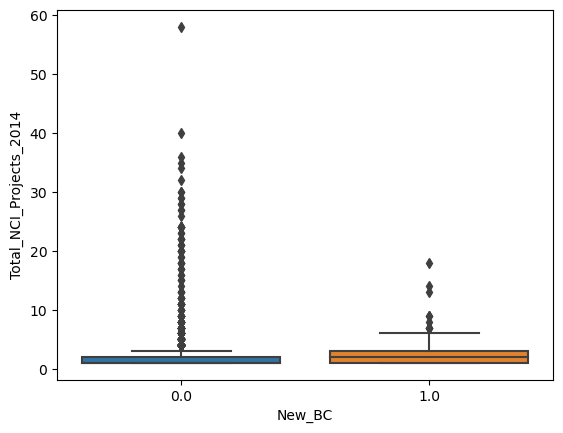

In [62]:
ax = sns.boxplot(x="New_BC", y="Total_NCI_Projects_2014", data=df_train)

We can see that PIs who will have a new brain cancer project between 2016-2020 have more NCI projects on average in 2014

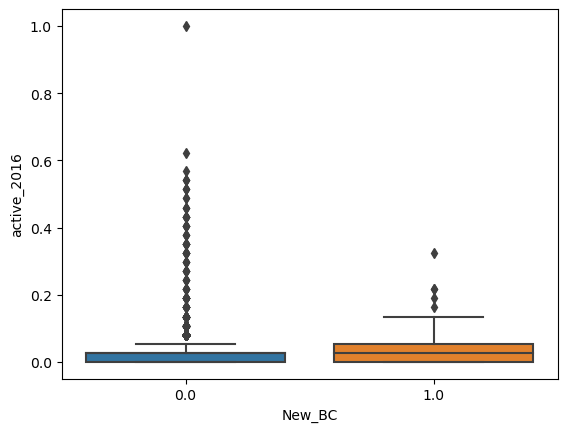

In [63]:
ax = sns.boxplot(x="New_BC", y="active_2016", data=df_train)

We can see that PIs who will have a new brain cancer project between 2016-2020 have more active projects in 2016.  

#### Identify the features and lable
We need to identify the **features** and **label** for both the trainig and test datasets

In [64]:
# use conventions typically used in python scikitlearn
X_train = df_train.drop(columns=['New_BC'])
y_train = df_train['New_BC']
X_test = df_test.drop(columns=['New_BC'])
y_test = df_test['New_BC']

# Model Selection

## Model Evaluation 

In this phase, you take the predictors from your test set and apply your model to them, then assess the quality of the model by comparing the *predicted values* to the *actual values* for each record in your testing data set. 

- **Performance Estimation**: How well will our model do once it is deployed and applied to new data?

Now let's use the model we just fit to make predictions on our test dataset, and see what our accuracy score is:

We will start with the simplest [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model and see how well that does.

You can use any number of metrics to judge your models, but we'll use [`accuracy_score()`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) (ratio of correct predictions to total number of predictions) as our measure.

In [65]:
from sklearn import linear_model

model = linear_model.LogisticRegression(max_iter = 100, intercept_scaling = 2, solver = "lbfgs")

model.fit( X_train, y_train)

print(model)
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

LogisticRegression(intercept_scaling=2)


When we print the model results, we see different parameters we can adjust as we refine the model based on running it against test data (values such as `intercept_scaling`, `max_iters`, `penalty`, and `solver`).  

Penalty L1: Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features.

C: Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.

To adjust these parameters, one would alter the call that creates the `LogisticRegression()` model instance, passing it one or more of these parameters with a value other than the default.  So, to re-fit the model with `max_iter` of 1000, `intercept_scaling` of 2, and `solver` of "lbfgs" (pulled from thin air as an example), you'd create your model as follows:

    model = LogisticRegression( max_iter = 1000, intercept_scaling = 2, solver = "lbfgs" )

The basic way to choose values for, or "tune," these parameters is the same as the way you choose a model: fit the model to your training data with a variety of parameters, and see which perform the best on the test set. An obvious drawback is that you can also *overfit* to your test set; in this case, you can alter your method of cross-validation.



# Model Evaluation 

Machine learning models usually do not produce a prediction (0 or 1) directly. Rather, models produce a score between 0 and 1 (that can sometimes be interpreted as a probability), which lets you more finely rank all of the examples from *most likely* to *least likely* to have label 1 (positive). This score is then turned into a 0 or 1 based on a user-specified threshold. For example, you might label all examples that have a score greater than 0.5 (1/2) as positive (1), but there's no reason that has to be the cutoff. 

In [66]:
#  from our "predictors" using the model.
y_scores = model.predict_proba(X_test)[:,1]

In [67]:
y_scores

array([2.04182963e-01, 2.04557973e-01, 1.17792380e-04, ...,
       1.01290015e-03, 1.65683802e-01, 1.33308408e-03])

Let's take a look at the distribution of scores and see if it makes sense to us. 

<AxesSubplot:>

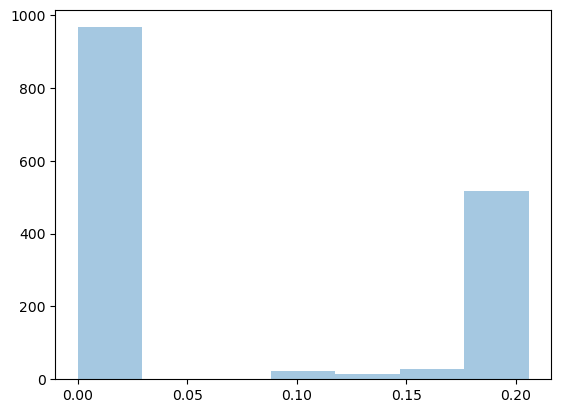

In [68]:
sns.distplot(y_scores, kde=False, rug=False)

Tools like `sklearn` often have a default threshold of 0.5, but a good threshold is selected based on the data, model and the specific problem you are solving. Looking at the distribution above, we can see that our model rarly assigns a value greater then 0.45, so as a trial run, let's set a threshold of 0.45 

In [69]:
calc_threshold = lambda x,y: 0 if x < y else 1 
predicted = np.array( [calc_threshold(score,0.45) for score in y_scores] )
expected = y_test

<AxesSubplot:xlabel='New_BC'>

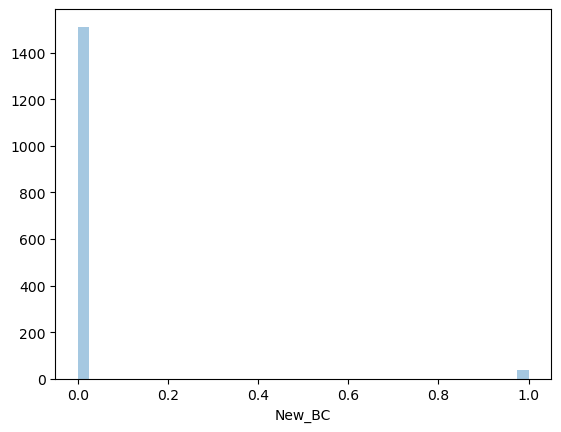

In [70]:
sns.distplot(expected, kde=False, rug=False)

## Confusion Matrix

Once we have tuned our scores to 0 or 1 for classification, we create a *confusion matrix*, which  has four cells: true negatives, true positives, false negatives, and false positives. Each data point belongs in one of these cells, because it has both a ground truth and a predicted label. If an example was predicted to be negative and is negative, it's a true negative. If an example was predicted to be positive and is positive, it's a true positive. If an example was predicted to be negative and is positive, it's a false negative. If an example was predicted to be positive and is negative, it's a false negative.
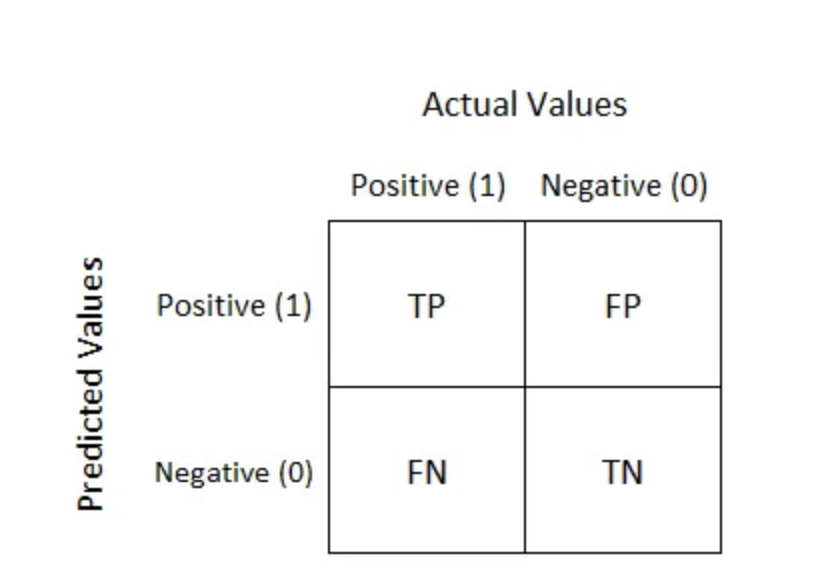

In [71]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(expected,predicted)
print(conf_matrix)

[[1512    0]
 [  37    0]]


#### Accuracy
Accuracy is the ratio of the correct predictions (both positive and negative) to all predictions. 
$$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN} $$

In [72]:
# generate an accuracy score by comparing expected to predicted.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(expected, predicted)
print( "Accuracy = " + str( accuracy ) )

Accuracy = 0.9761136216914138


#### Precision and Recall.
Two additional metrics that are often used are **precision** and **recall**. 

Precision measures the accuracy of the classifier when it predicts an example to be positive. It is the ratio of correctly predicted positive examples to examples predicted to be positive. 

$$ Precision = \frac{TP}{TP+FP}$$

Recall measures the accuracy of the classifier to find positive examples in the data. 

$$ Recall = \frac{TP}{TP+FN} $$

By selecting different thresholds we can vary and tune the precision and recall of a given classifier. A conservative classifier (threshold 0.99) will classify a case as 1 only when it is *very sure*, leading to high precision. On the other end of the spectrum, a low threshold (e.g. 0.01) will lead to higher recall. 

In [73]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(expected, predicted)
recall = recall_score(expected, predicted)
print( "Precision = " + str( precision ) )
print( "Recall= " + str(recall))

Precision = 0.0
Recall= 0.0


If we care about our whole precision-recall space, we can optimize for a metric known as the **area under the curve (AUC-PR)**, which is the area under the precision-recall curve. The maximum AUC-PR is 1. 

In [74]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.029165


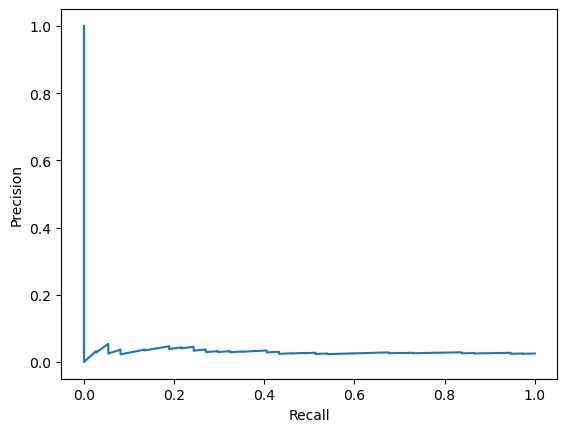

<Figure size 640x480 with 0 Axes>

In [75]:
plot_precision_recall(expected, y_scores)

## Precision and Recall at k%

If we only care about a specific part of the precision-recall curve we can focus on more fine-grained metrics. For instance, say NIH wants to host a workshop for people they think are likley to do brain cancer research in the future, The workshop is expensive so they only want to select the top 1% of people who are likley to do brain cancer researh in the future. In that case, we would want to prioritize the 1% of applicants who are *most likely* to have future brain cancer research, and it doesn't matter too much how accurate we are on the ones who aren't very likely to have brain cancer researh in the future. We can then focus on optimizing our **precision at 1%**.

In [76]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls 
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf()

In [77]:
def precision_at_k(y_true, y_scores,k):
    
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores ])
    return precision_score(y_true, y_pred)

<Figure size 640x480 with 0 Axes>

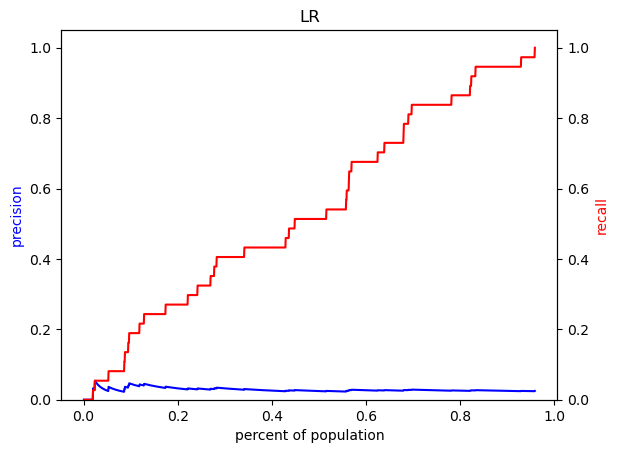

<Figure size 640x480 with 0 Axes>

In [78]:
plot_precision_recall_n(expected,y_scores, 'LR')

In [79]:
p_at_1 = precision_at_k(expected,y_scores, 0.01)
print('Precision at 1%: {:.2f}'.format(p_at_1))

Precision at 1%: 0.00


# Assess Model Against Baselines


It is important to check our model against a reasonable **baseline** to know how well our model is doing. Without any context, .57% accuracy does not sound great... but that really depends on how well you would do by declaring everyone will not no Cancer researcher in the future, which would be stupid (not to mention useless) model. 

A good place to start is checking against a *random* baseline, assigning every example a label (positive or negative) completely at random. 

In [80]:
random_score = [random.uniform(0,1) for i in enumerate(y_test)] 
random_predicted = np.array( [calc_threshold(score,0.5) for score in random_score] )
random_p_at_5 = precision_at_k(expected,random_predicted, 0.01)
print('Precision at 1% (random): {:.2f}'.format(random_p_at_5))

Precision at 1% (random): 0.02


## Check point 2
### 1) Formulate a prediction problem that is relavent your project (2 points)

   

### My Machine Learning Problem
In the following notebook, I will build a model to predict what PIs who work on NCI projects in 2014 will NOT begin a new project researchering HPV after the Cancer moonshot initiative.

MG comment: It is not clear to me why it is valuable to predict which of the PIs who work on NCI projects in 2014 will NOT begin a new project researching HPV after the Cancer moonshot initiative. I appreciate that you tried to change things up a bit, but this needed further explanation to convince me it was a worthwhile prediction problem. (-1 point)


2) Read in your own data and select the appropriate subset of variables and observations(1 point)

  

In [81]:
# Specify a path with the data folder
# Change "NAME" to your name as recorded on your computer
# path = 'C:/Users/NAME/PADM-GP_2505/Data/'
Path = "/Users/wsq/Desktop/Advanced Data Analytics and Evidence Building/PADM-GP_2505/Data"

# use the chdir funftion from the os package to sed your working directory 
os.chdir(Path + "/Projects")

In [82]:
# Read-in the 2014 projects file
grants_2014 = pd.read_csv('/Users/wsq/Desktop/Advanced Data Analytics and Evidence Building/PADM-GP_2505/Data/Projects/RePORTER_PRJ_C_FY2014_new.csv', encoding='latin-1')

In [83]:
grants_2014.head()

,APPLICATION_ID,ACTIVITY,ADMINISTERING_IC,APPLICATION_TYPE,ARRA_FUNDED,AWARD_NOTICE_DATE,BUDGET_START,BUDGET_END,CFDA_CODE,CORE_PROJECT_NUM,...,SERIAL_NUMBER,STUDY_SECTION,STUDY_SECTION_NAME,SUBPROJECT_ID,SUFFIX,SUPPORT_YEAR,DIRECT_COST_AMT,INDIRECT_COST_AMT,TOTAL_COST,TOTAL_COST_SUB_PROJECT
0,8759648,U2G,PS,3.0,N,11/5/2013,9/30/2013,9/29/2015,67.0,U2GPS002070,...,2070,ZPS1,Special Emphasis Panel,NaN,S1,5.0,NaN,NaN,6232229.0,NaN
1,8715629,R44,CA,2.0,N,7/30/2014,8/1/2014,7/31/2015,395.0,R44CA121740,...,121740,ZRG1,Special Emphasis Panel,NaN,NaN,2.0,NaN,NaN,647919.0,NaN
2,8676705,R01,CA,5.0,N,9/16/2014,9/1/2014,5/31/2016,393.0,R01CA149025,...,149025,ZRG1,Special Emphasis Panel,NaN,NaN,5.0,383766.0,200662.0,584428.0,NaN
3,8627980,R44,HL,5.0,N,12/24/2013,1/1/2014,3/31/2015,837.0,R44HL108542,...,108542,ZRG1,Special Emphasis Panel,NaN,NaN,3.0,NaN,NaN,563854.0,NaN
4,8609633,UM1,AI,2.0,N,12/10/2013,12/1/2013,11/30/2014,855.0,UM1AI069439,...,69439,ZAI1,Special Emphasis Panel,NaN,NaN,8.0,2183941.0,760075.0,2716438.0,NaN


In [84]:
grants_2014[['APPLICATION_ID','FY', 'IC_NAME', 'PI_IDS','PROJECT_START', 'NIH_SPENDING_CATS']].head()

,APPLICATION_ID,FY,IC_NAME,PI_IDS,PROJECT_START,NIH_SPENDING_CATS
0,8759648,2014,"National Center for HIV/AIDS, Viral Hepatitis,...",11600459;,9/30/2009,NaN
1,8715629,2014,NATIONAL CANCER INSTITUTE,8495898 (contact); 1888559;,2/1/2006,Bioengineering; Cancer; Contraception/Reproduc...
2,8676705,2014,NATIONAL CANCER INSTITUTE,3150322;,8/1/2010,Breast Cancer; Cancer; Clinical Research; Clin...
3,8627980,2014,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",8079908 (contact); 9243547;,7/5/2012,Bioengineering; Brain Disorders; Cardiovascula...
4,8609633,2014,NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS D...,1874862; 1985665 (contact); 1944840;,2/1/2007,Clinical Research; Clinical Trials; HIV/AIDS; ...


In [85]:
grants_2014 = grants_2014.reset_index()

# First we need to convert PI_IDS into a string variable
grants_2014['PI_IDS'] = grants_2014['PI_IDS'].astype(str)

# Make a temperary dataframe that creates an observation for each PI. 
# Use the explode function to split the PI_IDS at the ;
temp = grants_2014['PI_IDS'].str.split(';').explode().reset_index()

# Rename the PI_IDS variable
temp = temp.rename(columns = {'PI_IDS': 'PI_ID'})

# Replace " " with and emplty string
temp['PI_ID'] = temp['PI_ID'].str.replace(' ','')

# Only keep observations in the temp dataframe where PI_ID is not an empty string or a sting with a single space
temp = temp[temp['PI_ID'] !=""]
temp = temp[temp['PI_ID'] !=" "]
temp = temp[temp['PI_ID'] !="  "]

# For the the PI_ID variable, use the str.replace fundtion to replace ` (contact)` with nothing 
temp['PI_ID'] = temp['PI_ID'].str.replace('\(contact\)', '')

# Merge this temperary dataframe with grants_2014
grants_2014B = grants_2014.merge(temp, on = 'index')

# Filter for NCI prpjects
grants_2014B = grants_2014B[grants_2014B['IC_NAME'] == 'NATIONAL CANCER INSTITUTE']

# Exclude HPV NCI projects
#grants_2014B = grants_2014B[~grants_2014B['NIH_SPENDING_CATS'].str.contains('HPV', na=False)]

# view the select variables for the firts 5 observations
grants_2014B[['APPLICATION_ID', 'PI_NAMEs', 'PI_ID','PI_IDS','FY','FULL_PROJECT_NUM', 'PROJECT_TITLE','PROJECT_START', 'PROJECT_END', 'TOTAL_COST']].head()


,APPLICATION_ID,PI_NAMEs,PI_ID,PI_IDS,FY,FULL_PROJECT_NUM,PROJECT_TITLE,PROJECT_START,PROJECT_END,TOTAL_COST
1,8715629,"BURDETTE, EVERETTE C (contact); DIEDERICH, CHR...",8495898,8495898 (contact); 1888559;,2014,2R44CA121740-02,Minimally Invasive High Intensity Ultrasound T...,2/1/2006,7/31/2016,647919.0
2,8715629,"BURDETTE, EVERETTE C (contact); DIEDERICH, CHR...",1888559,8495898 (contact); 1888559;,2014,2R44CA121740-02,Minimally Invasive High Intensity Ultrasound T...,2/1/2006,7/31/2016,647919.0
3,8676705,"BICKELL, NINA A;",3150322,3150322;,2014,5R01CA149025-05,Implementing a Tracking & Feedback Registry to...,8/1/2010,5/31/2016,584428.0
17,8616355,"TUSCHL, THOMAS ;",7337985,7337985;,2014,5R01CA159227-04,Development of quantitative multiplex RNA in s...,3/1/2011,2/29/2016,345751.0
19,8585032,"BESSLER, MONICA ;",3144163,3144163;,2014,5R01CA105312-09,MOLECULAR STUDIES OF BONE MARROW FAILURE,12/1/2003,8/31/2015,561426.0


3) Create a lable that will allow you to address the problem you stated in #1 (1 point)

   

In [86]:
# Identify the files you want to read in
years = ('RePORTER_PRJ_C_FY2016_new.csv', 'RePORTER_PRJ_C_FY2017_new.csv', 'RePORTER_PRJ_C_FY2018_new.csv', 'RePORTER_PRJ_C_FY2019_new.csv', 'RePORTER_PRJ_C_FY2020_new.csv')

In [87]:
# Generate an empty dataframe that will hold all the patent data we have
NCI_2016_2020 = pd.DataFrame([])

# Now loop through each file identified in the years vector
# Read that file using only the columns we need
# And append it to the dataframe that we created above
# This might take a little while to run (no more than 1 minute)
for counter, file in enumerate(years):
    print(counter,file)
    projects = pd.read_csv(file, usecols=['APPLICATION_ID','FY', 'IC_NAME', 'PI_IDS','PROJECT_START', 'NIH_SPENDING_CATS'], 
                           encoding='latin-1')
     # Filter for NCI prpjects
    projects = projects[projects['IC_NAME'] == 'NATIONAL CANCER INSTITUTE']
    
    # Select HPV NCI projects 
    #projects = projects[projects['NIH_SPENDING_CATS'].str.contains('HPV', na = False)]

    # Exclude HPV NCI projects
    projects = projects[projects['NIH_SPENDING_CATS'].str.contains('HPV', na = False)]
    
    # convert PROJECT_START into a date variable
    projects =projects['PROJECT_START'] = pd.to_datetime(projects['PROJECT_START'])
    
    NCI_2016_2020 = NCI_2016_2020.append(projects)
    
NCI_2016_2020 = NCI_2016_2020.reset_index(drop=True)
NCI_2016_2020.head(20)

0 RePORTER_PRJ_C_FY2016_new.csv
1 RePORTER_PRJ_C_FY2017_new.csv
2 RePORTER_PRJ_C_FY2018_new.csv
3 RePORTER_PRJ_C_FY2019_new.csv
4 RePORTER_PRJ_C_FY2020_new.csv


,1003,1795,3161,4070,4677,6718,9325,12737,13272,15289,...,74049,75678,75691,76640,77251,77415,79102,81546,81917,82058
0,NaT,2015-08-15,2005-04-08,2016-07-15,2016-08-01,NaT,NaT,2016-09-15,NaT,2016-04-14,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,2020-09-18,2017-02-03,2020-03-01,2020-08-10,2019-09-12,2020-08-31,NaT,2010-07-01,2003-09-30,NaT


In [88]:
# Generate an empty dataframe that will hold all the patent data we have
NCI_2016_2020 = pd.DataFrame([])

# Now loop through each file identified in the years vector
# Read that file using only the columns we need
# And append it to the dataframe that we created above
# This might take a little while to run (no more than 1 minute)
for counter, file in enumerate(years):
    print(counter,file)
    projects = pd.read_csv(file, usecols=['APPLICATION_ID','FY', 'IC_NAME', 'PI_IDS','PROJECT_START', 'NIH_SPENDING_CATS'], 
                           encoding='latin-1')
     # Filter for NCI prpjects
    projects = projects[projects['IC_NAME'] == 'NATIONAL CANCER INSTITUTE']
    # Select HPV NCI projects 
    projects = projects[~projects['NIH_SPENDING_CATS'].str.contains('HPV', na = False)]
    
    # convert PROJECT_START into a date variable
    projects['PROJECT_START'] = pd.to_datetime(projects['PROJECT_START'])

    NCI_2016_2020 = NCI_2016_2020.append(projects)
    
NCI_2016_2020 = NCI_2016_2020.reset_index(drop=True)
NCI_2016_2020.head(20)

0 RePORTER_PRJ_C_FY2016_new.csv
1 RePORTER_PRJ_C_FY2017_new.csv
2 RePORTER_PRJ_C_FY2018_new.csv
3 RePORTER_PRJ_C_FY2019_new.csv
4 RePORTER_PRJ_C_FY2020_new.csv


,APPLICATION_ID,FY,IC_NAME,NIH_SPENDING_CATS,PI_IDS,PROJECT_START
0,9036357,2016,NATIONAL CANCER INSTITUTE,Aging; Cancer; Clinical Research; Prostate Can...,1866031; 1880492 (contact); 9197685; 6667892;,2015-04-01
1,9047257,2016,NATIONAL CANCER INSTITUTE,Cancer; Diagnostic Radiology;,1858946 (contact); 9880120;,2015-04-06
2,9264070,2016,NATIONAL CANCER INSTITUTE,Cancer; Complementary and Alternative Medicine...,1860747 (contact); 2026105;,2012-08-14
3,9057474,2016,NATIONAL CANCER INSTITUTE,Aging; Cancer; Prostate Cancer; Regenerative M...,2564393;,2012-08-01
4,9125588,2016,NATIONAL CANCER INSTITUTE,Aging; Behavioral and Social Science; Cancer; ...,2429035; 6802765; 1942894 (contact);,2016-09-20
5,9178971,2016,NATIONAL CANCER INSTITUTE,Cancer; Clinical Research; Prevention;,1912832;,1997-01-01
6,9109590,2016,NATIONAL CANCER INSTITUTE,Aging; Bioengineering; Cancer; Clinical Resear...,6375366; 6060960 (contact);,2015-07-14
7,9353540,2016,NATIONAL CANCER INSTITUTE,Cancer; Clinical Research; Prevention; Rural H...,1860389; 7008046 (contact); 7809558;,2005-09-30
8,9132671,2016,NATIONAL CANCER INSTITUTE,Breast Cancer; Cancer; Clinical Research; Clin...,11184125 (contact); 10433776; 2423744; 7821138...,2010-05-01
9,9127093,2016,NATIONAL CANCER INSTITUTE,NaN,1921608; 1860749 (contact);,2007-09-30


In [89]:
# reset the index
NCI_2016_2020 = NCI_2016_2020.reset_index()

# view the firts 5 observations
NCI_2016_2020.head()

,index,APPLICATION_ID,FY,IC_NAME,NIH_SPENDING_CATS,PI_IDS,PROJECT_START
0,0,9036357,2016,NATIONAL CANCER INSTITUTE,Aging; Cancer; Clinical Research; Prostate Can...,1866031; 1880492 (contact); 9197685; 6667892;,2015-04-01
1,1,9047257,2016,NATIONAL CANCER INSTITUTE,Cancer; Diagnostic Radiology;,1858946 (contact); 9880120;,2015-04-06
2,2,9264070,2016,NATIONAL CANCER INSTITUTE,Cancer; Complementary and Alternative Medicine...,1860747 (contact); 2026105;,2012-08-14
3,3,9057474,2016,NATIONAL CANCER INSTITUTE,Aging; Cancer; Prostate Cancer; Regenerative M...,2564393;,2012-08-01
4,4,9125588,2016,NATIONAL CANCER INSTITUTE,Aging; Behavioral and Social Science; Cancer; ...,2429035; 6802765; 1942894 (contact);,2016-09-20


In [90]:
# Merge this temperary dataframe with grants_2017
NCI_2016_2020B = NCI_2016_2020.merge(temp, on = 'index')

# view the firts 5 observations
NCI_2016_2020B.head(10)

,index,APPLICATION_ID,FY,IC_NAME,NIH_SPENDING_CATS,PI_IDS,PROJECT_START,PI_ID
0,0,9036357,2016,NATIONAL CANCER INSTITUTE,Aging; Cancer; Clinical Research; Prostate Can...,1866031; 1880492 (contact); 9197685; 6667892;,2015-04-01,11600459
1,1,9047257,2016,NATIONAL CANCER INSTITUTE,Cancer; Diagnostic Radiology;,1858946 (contact); 9880120;,2015-04-06,8495898
2,1,9047257,2016,NATIONAL CANCER INSTITUTE,Cancer; Diagnostic Radiology;,1858946 (contact); 9880120;,2015-04-06,1888559
3,2,9264070,2016,NATIONAL CANCER INSTITUTE,Cancer; Complementary and Alternative Medicine...,1860747 (contact); 2026105;,2012-08-14,3150322
4,3,9057474,2016,NATIONAL CANCER INSTITUTE,Aging; Cancer; Prostate Cancer; Regenerative M...,2564393;,2012-08-01,8079908
5,3,9057474,2016,NATIONAL CANCER INSTITUTE,Aging; Cancer; Prostate Cancer; Regenerative M...,2564393;,2012-08-01,9243547
6,4,9125588,2016,NATIONAL CANCER INSTITUTE,Aging; Behavioral and Social Science; Cancer; ...,2429035; 6802765; 1942894 (contact);,2016-09-20,1874862
7,4,9125588,2016,NATIONAL CANCER INSTITUTE,Aging; Behavioral and Social Science; Cancer; ...,2429035; 6802765; 1942894 (contact);,2016-09-20,1985665
8,4,9125588,2016,NATIONAL CANCER INSTITUTE,Aging; Behavioral and Social Science; Cancer; ...,2429035; 6802765; 1942894 (contact);,2016-09-20,1944840
9,5,9178971,2016,NATIONAL CANCER INSTITUTE,Cancer; Clinical Research; Prevention;,1912832;,1997-01-01,8627613


In [91]:
# Define the start as the pridr day in Fiscal year 2016
Start_date = pd.to_datetime('10/01/2015')

# select all nci projects (that started after FY 2016)
New_NCI_PI = NCI_2016_2020B[NCI_2016_2020B['PROJECT_START'] >= Start_date]

# Reset index
New_NCI_PI = New_NCI_PI.reset_index()

# view the firts 5 observations
New_NCI_PI.head()

,level_0,index,APPLICATION_ID,FY,IC_NAME,NIH_SPENDING_CATS,PI_IDS,PROJECT_START,PI_ID
0,6,4,9125588,2016,NATIONAL CANCER INSTITUTE,Aging; Behavioral and Social Science; Cancer; ...,2429035; 6802765; 1942894 (contact);,2016-09-20,1874862
1,7,4,9125588,2016,NATIONAL CANCER INSTITUTE,Aging; Behavioral and Social Science; Cancer; ...,2429035; 6802765; 1942894 (contact);,2016-09-20,1985665
2,8,4,9125588,2016,NATIONAL CANCER INSTITUTE,Aging; Behavioral and Social Science; Cancer; ...,2429035; 6802765; 1942894 (contact);,2016-09-20,1944840
3,17,13,9155094,2016,NATIONAL CANCER INSTITUTE,Aging; Cancer; Clinical Research; Genetics; Pr...,12300579;,2016-08-26,7337985
4,19,15,9172374,2016,NATIONAL CANCER INSTITUTE,Cancer; Digestive Diseases; Neurosciences;,1890362;,2016-09-07,3144163


In [92]:
New_NCI_PI = New_NCI_PI[['PI_ID']].drop_duplicates()
New_NCI_PI["New_HPV"] = 1

# view the select variables for the firts 4 observations
New_NCI_PI.head(8)

,PI_ID,New_HPV
0,1874862,1
1,1985665,1
2,1944840,1
3,7337985,1
4,3144163,1
5,6666441,1
6,6579212,1
7,1898902,1


In [93]:
# Merge the temp dataframe into the DF_2015 data frame 
# Use an left merge
# keep only the PI_ID and NCI_2017 variables and then drop duplicates. This will give us one observation per person
DF = pd.merge(grants_2014B, New_NCI_PI, on='PI_ID', how = 'left')[['PI_ID','New_HPV']].drop_duplicates()
DF.head()

,PI_ID,New_HPV
0,8495898,NaN
1,1888559,NaN
2,3150322,NaN
3,7337985,1.0
4,3144163,1.0


In [94]:
DF['New_HPV'] = DF['New_HPV'].fillna(0)

DF.head()

,PI_ID,New_HPV
0,8495898,0.0
1,1888559,0.0
2,3150322,0.0
3,7337985,1.0
4,3144163,1.0


In [95]:
DF.shape

(7741, 2)

In [96]:
sum(DF['New_HPV'])

3691.0

 4) Create at least 5 different feature groups (a group can be a single feature like normalized total cost, or a group of dummy variables like spending catagory variables) (2 point)


### Spending Catagory

In [97]:
grants_2014B[['NIH_SPENDING_CATS']].head()

,NIH_SPENDING_CATS
1,Bioengineering; Cancer; Contraception/Reproduc...
2,Bioengineering; Cancer; Contraception/Reproduc...
3,Breast Cancer; Cancer; Clinical Research; Clin...
17,Biotechnology; Cancer; Clinical Research; Gene...
19,Cancer; Clinical Research; Genetics; Hematolog...


#### Seperate up the Spending Catagory

In [98]:
# First we need to convert PI_IDS into a string variable
grants_2014B['PI_IDS'] = grants_2014B['NIH_SPENDING_CATS'].astype(str)

# Make a temporary dataframe that creates an observation for each spending catagory
# Use the explode function to split the NIH_SPENDING_CATS at the ;
temp = grants_2014B['NIH_SPENDING_CATS'].str.split(';').explode().reset_index()

# Rename the NIH_SPENDING_CATS variable
temp = temp.rename(columns = {'NIH_SPENDING_CATS': 'NIH_SPENDING_CAT'})

# Replace " " with and emplty string
temp['NIH_SPENDING_CAT'] = temp['NIH_SPENDING_CAT'].str.replace(' ','')


# Only keep observations in the temp dataframe where PI_ID is not an empty string
temp = temp[temp['NIH_SPENDING_CAT'] !=""]

temp.head(10)

,index,NIH_SPENDING_CAT
0,1,Bioengineering
1,1,Cancer
2,1,Contraception/Reproduction
3,1,DiagnosticRadiology
4,1,FibroidTumors(Uterine)
6,2,Bioengineering
7,2,Cancer
8,2,Contraception/Reproduction
9,2,DiagnosticRadiology
10,2,FibroidTumors(Uterine)


In [99]:
# Select the relavent columns 
Cat = grants_2014B[['index', 'PI_ID', 'NIH_SPENDING_CATS']]

Cat.head()

,index,PI_ID,NIH_SPENDING_CATS
1,1,8495898,Bioengineering; Cancer; Contraception/Reproduc...
2,1,1888559,Bioengineering; Cancer; Contraception/Reproduc...
3,2,3150322,Breast Cancer; Cancer; Clinical Research; Clin...
17,13,7337985,Biotechnology; Cancer; Clinical Research; Gene...
19,15,3144163,Cancer; Clinical Research; Genetics; Hematolog...


In [100]:
# Merge this temporary dataframe with the spending catagory dataframe
Cat2 = Cat.merge(temp, on = 'index')

# Remove the index and NIH_SPENDING_CATS variables
Cat2 = Cat2.drop(columns=['index', 'NIH_SPENDING_CATS'])

# Drop duplicate observations
Cat2 = Cat2.drop_duplicates()

# Drop duplicate observations
Cat2['Cat'] = 1

# View the first 10 observations
Cat2.head(10)


,PI_ID,NIH_SPENDING_CAT,Cat
0,8495898,Bioengineering,1
1,8495898,Cancer,1
2,8495898,Contraception/Reproduction,1
3,8495898,DiagnosticRadiology,1
4,8495898,FibroidTumors(Uterine),1
5,1888559,Bioengineering,1
6,1888559,Cancer,1
7,1888559,Contraception/Reproduction,1
8,1888559,DiagnosticRadiology,1
9,1888559,FibroidTumors(Uterine),1


In [101]:
# use the pivot function to transform the dataframe from long to wide
Cat3 = pd.pivot(Cat2, index='PI_ID', columns = 'NIH_SPENDING_CAT',values = 'Cat')

#Re-arange the new columns in the correct order
cols = Cat2['NIH_SPENDING_CAT'].unique()
Cat3=Cat3[cols]

# Replace missing values with 0
Cat3 = Cat3.fillna(0)

# View the first 5 observations
Cat3.head()

NIH_SPENDING_CAT,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,BreastCancer,ClinicalResearch,...,Crohn'sDisease,InflammatoryBowelDisease,DigestiveDiseases-(Gallbladder),Asthma,ChronicObstructivePulmonaryDisease,StemCellResearch-UmbilicalCordBlood/Placenta-Human,Hepatitis-C,GeneTherapyClinicalTrials,Arthritis,Infertility
PI_ID,,,,,,,,,,,,,,,,,,,,,
10012000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10021262,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10021476,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10108300,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10113370,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
# Join Cat3 with the DF fataframe using a left join
DF = pd.merge(DF, Cat3, on = 'PI_ID',  how = 'left')

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,Crohn'sDisease,InflammatoryBowelDisease,DigestiveDiseases-(Gallbladder),Asthma,ChronicObstructivePulmonaryDisease,StemCellResearch-UmbilicalCordBlood/Placenta-Human,Hepatitis-C,GeneTherapyClinicalTrials,Arthritis,Infertility
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### State

In [103]:
state = grants_2014B[['PI_ID', 'ORG_STATE']]

# Drop duplicate observations
state = state.drop_duplicates()

# Only keep the first state reccorded for each PI
state = state.groupby(['PI_ID']).first()

# View the first 5 observations
state.head()

,ORG_STATE
PI_ID,
10000506,None
10011128,AZ
10012000,MA
10021262,ON
10021476,NY


In [104]:
# We need to creat dummy variables for state and organization name
state2 = pd.get_dummies(state, columns=['ORG_STATE'])

state2.head()

,ORG_STATE_AK,ORG_STATE_AL,ORG_STATE_AR,ORG_STATE_AZ,ORG_STATE_BC,ORG_STATE_CA,ORG_STATE_CO,ORG_STATE_CT,ORG_STATE_DC,ORG_STATE_DE,...,ORG_STATE_SC,ORG_STATE_SD,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV
PI_ID,,,,,,,,,,,,,,,,,,,,,
10000506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10011128,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10012000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10021262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10021476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
state2.shape

(7741, 53)

In [106]:
# Select the relavant columns
State_temp = grants_2014B[['index','PI_ID', 'ORG_STATE']]
State_temp.head()

,index,PI_ID,ORG_STATE
1,1,8495898,IL
2,1,1888559,IL
3,2,3150322,NY
17,13,7337985,NY
19,15,3144163,PA


In [107]:
# Merge this temporary dataframe with the spending catagory dataframe
State_temp2 = State_temp.merge(temp, on = 'index')

# Remove the index and NIH_SPENDING_CATS variables
State_temp2 = State_temp2.drop(columns=['index', 'NIH_SPENDING_CAT'])

# Drop duplicate observations
State_temp2 = State_temp2.drop_duplicates()

# Drop duplicate observations
State_temp2['State_temp'] = 1

# View the first 10 observations
State_temp2.head(10)

,PI_ID,ORG_STATE,State_temp
0,8495898,IL,1
5,1888559,IL,1
10,3150322,NY,1
15,6265424,NY,1
19,12448156,NaN,1
23,1869066,HI,1
27,12430520,CA,1
34,8590003,TN,1
36,1877317,TN,1
38,7284983,WA,1


In [108]:
# use the pivot function to transform the dataframe from long to wide
State_temp3 = pd.pivot(State_temp2, index='PI_ID', columns = 'ORG_STATE',values = 'State_temp')

#Re-arange the new columns in the correct order
cols = State_temp2['ORG_STATE'].unique()
State_temp3=State_temp3[cols]

# Replace missing values with 0
State_temp3 = State_temp3.fillna(0)

# View the first 5 observations
State_temp3.head()

ORG_STATE,IL,NY,NaN,HI,CA,TN,WA,MA,KS,OR,...,VT,MS,QC,LA,SD,PR,NV,DE,OK,ON
PI_ID,,,,,,,,,,,,,,,,,,,,,
10012000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10021262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10021476,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10108300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10113370,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
# Join Cat3 with the DF fataframe using a left join
DF = pd.merge(DF, State_temp3, on = 'PI_ID',  how = 'left')

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,VT,MS,QC,LA,SD,PR,NV,DE,OK,ON
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
# Join Cat3 with the DF fataframe using a left join
DF = pd.merge(DF, State_temp3, on = 'PI_ID',  how = 'left')

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,VT_y,MS_y,QC_y,LA_y,SD_y,PR_y,NV_y,DE_y,OK_y,ON_y
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
# We need to creat dummy variables for state and organization name
state2 = pd.get_dummies(state, columns=['ORG_STATE'])

state2.head()

,ORG_STATE_AK,ORG_STATE_AL,ORG_STATE_AR,ORG_STATE_AZ,ORG_STATE_BC,ORG_STATE_CA,ORG_STATE_CO,ORG_STATE_CT,ORG_STATE_DC,ORG_STATE_DE,...,ORG_STATE_SC,ORG_STATE_SD,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV
PI_ID,,,,,,,,,,,,,,,,,,,,,
10000506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10011128,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10012000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10021262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10021476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
state2.shape

(7741, 53)

In [113]:
# use a left join nerge to join the state2 data witht the DF dataframe
DF = pd.merge(DF, state2, on = 'PI_ID',  how = 'left')

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_SC,ORG_STATE_SD,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [114]:
# Calculate how many Projects each PI has
projects = grants_2014B.groupby(['PI_ID'])['APPLICATION_ID'].nunique().sort_values(ascending=False)

# Convert into a dataframe and reset index
projects = projects.to_frame().reset_index()

# Rename APPLICATION_ID to Total_NCI_Projects_2014
projects.rename(columns={'APPLICATION_ID':'Total_NCI_Projects_2014'}, inplace = True)

# View the first 2 observations 
projects.head(2)

,PI_ID,Total_NCI_Projects_2014
0,14267998,58
1,1875698,40


### Number of projects in 2014

In [115]:
# Calculate how many Projects each PI has
projects = grants_2014B.groupby(['PI_ID'])['APPLICATION_ID'].nunique().sort_values(ascending=False)

# Convert into a dataframe and reset index
projects = projects.to_frame().reset_index()

# Rename APPLICATION_ID to Total_NCI_Projects_2014
projects.rename(columns={'APPLICATION_ID':'Total_NCI_Projects_2014'}, inplace = True)

# View the first 2 observations 
projects.head(2)

,PI_ID,Total_NCI_Projects_2014
0,14267998,58
1,1875698,40


In [116]:
DF = pd.merge(DF, projects, on = 'PI_ID',  how = 'inner')

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_SD,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,6
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1


### Number of projects what will still be active in  FY 2016

In [117]:
# convert PROJECT_END into a date variable
grants_2014B['PROJECT_END'] = pd.to_datetime(grants_2014['PROJECT_END'])

In [118]:
# Idenfity the end of FY 2015
FY_2016 = pd.to_datetime('09/30/2015')

# Filter for projects that will still me active in 2016
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2016]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2016' that is equal to one for all observations
ongoing['active_2016'] = 1

# View the first 2 observations 
ongoing.head(2)

,PI_ID,active_2016
1,8495898,1
2,1888559,1


In [119]:
# Sum up the number of projects that will still be active in 2016 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2016'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# View the first 2 observations 
ongoing.head(2)

,PI_ID,active_2016
0,10000506,1
1,10011128,1


In [120]:
# convert PROJECT_END into a date variable
grants_2014B['PROJECT_END'] = pd.to_datetime(grants_2014['PROJECT_END'])

In [121]:
# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2017 with 0
DF['active_2016'] = DF['active_2016'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_TN,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,2,1.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,6,3.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,1.0


### Number of projects what will still be active in FY 2017

In [122]:
# Idenfity the end of FY 2016
FY_2017 = pd.to_datetime('09/30/2016')

# Filter for projects that will still me active in 2017
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2017]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2017' that is equal to one for all observations
ongoing['active_2017'] = 1

# Sum up the number of projects that will still be active in 2017 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2017'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2017 with 0
DF['active_2017'] = DF['active_2017'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_TX,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,2,1.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,6,3.0,2.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,1.0,0.0


### Number of projects what will still be active in FY 2018

In [123]:
# Idenfity the end of FY 2017
FY_2018 = pd.to_datetime('09/30/2017')

# Filter for projects that will still me active in 2016
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2018]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2018' that is equal to one for all observations
ongoing['active_2018'] = 1

# Sum up the number of projects that will still be active in 2018 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2018'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2018 with 0
DF['active_2018'] = DF['active_2018'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_UT,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,2,1.0,0.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,6,3.0,2.0,0.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,1.0,0.0,0.0


### Number of projects what will still be active in FY 2019

In [124]:
# Idenfity the end of FY 2018
FY_2019 = pd.to_datetime('09/30/2018')

# Filter for projects that will still me active in 2019
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2019]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2019' that is equal to one for all observations
ongoing['active_2019'] = 1

# Sum up the number of projects that will still be active in 2019 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2019'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2019 with 0
DF['active_2019'] = DF['active_2019'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_VA,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,2,1.0,0.0,0.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,6,3.0,2.0,0.0,0.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,1.0,0.0,0.0,0.0


### Number of projects what will still be active in FY 2020

In [125]:
# Idenfity the end of FY 2019
FY_2020 = pd.to_datetime('09/30/2019')

# Filter for projects that will still me active in 2020
ongoing = grants_2014B[grants_2014B['PROJECT_END'] > FY_2020]

# select only the PI_ID variable 
ongoing = ongoing[['PI_ID']]

# Create a new variable 'active_2020' that is equal to one for all observations
ongoing['active_2020'] = 1

# Sum up the number of projects that will still be active in 2020 for each PI
ongoing = ongoing.groupby('PI_ID')['active_2020'].sum()

# Convert into a dataframe and reset index
ongoing = ongoing.to_frame().reset_index()

# Merge the temp dataframe into the DF data frame 
# Use an left merge
DF = pd.merge(DF, ongoing, on='PI_ID', how = 'left')

# Fill the NaN values for active_2020 with 0
DF['active_2020'] = DF['active_2020'].fillna(0)

# View the first 5 observations
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_VT,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,2,1.0,0.0,0.0,0.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,6,3.0,2.0,0.0,0.0,0.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0


### Total Cost of Projects

In [126]:
# Calculate how many Projects each PI has
Cost = grants_2014B.groupby(['PI_ID'])['TOTAL_COST'].sum()

# Convert into a dataframe and reset index
Cost = Cost.to_frame().reset_index()

# drop first row
Cost = Cost.iloc[1:, :]

# View the first 5 observations 
Cost.head()

,PI_ID,TOTAL_COST
1,10011128,750566.0
2,10012000,85785.0
3,10021262,217377.0
4,10021476,278247.0
5,10027192,310470.0


In [127]:
DF = pd.merge(DF, Cost, on = 'PI_ID',  how = 'left')
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_WA,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,647919.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,647919.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,2,1.0,0.0,0.0,0.0,0.0,584429.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,6,3.0,2.0,0.0,0.0,0.0,1765884.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,561426.0


### Number of NCI projcts by orginization 

In [128]:
# Use a conditional statement do create a new dataframe were there are only projects where the IC_NAME is NATIONAL CANCER INSTITUTE. 
HPV = grants_2014B[grants_2014B['NIH_SPENDING_CATS'].str.contains('HPV', na = False)]
    
# Calculate how many NCI Projects each ORG has
HPV = HPV.groupby(['ORG_NAME'])['APPLICATION_ID'].nunique().sort_values(ascending=False)

# Convert into a dataframe and reset index
HPV = HPV.to_frame().reset_index()

# Rename APPLICATION_ID to Total_BC_Projects_by_ORG
HPV.rename(columns={'APPLICATION_ID':'Total_HPV_Projects_by_ORG'}, inplace = True)

# View the first 5 observations 
HPV.head()


,ORG_NAME,Total_HPV_Projects_by_ORG
0,JOHNS HOPKINS UNIVERSITY,7
1,CANCER EPIDEMIOLOGY AND GENETICS,5
2,UT SOUTHWESTERN MEDICAL CENTER,3
3,"UNIVERSITY OF CALIFORNIA, SAN FRANCISCO",3
4,ALBERT EINSTEIN COLLEGE OF MEDICINE,2


In [129]:
HPV2 = pd.merge(grants_2014B, HPV, on = 'ORG_NAME',  how = 'left')[[ 'PI_ID', 'Total_HPV_Projects_by_ORG', 'ORG_NAME']]

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
HPV2['Total_HPV_Projects_by_ORG'] = HPV2['Total_HPV_Projects_by_ORG'].fillna(0)

#Drop duplicate observations
HPV2 = HPV2.drop_duplicates()

# View the first 5 observations
HPV2.head()

,PI_ID,Total_HPV_Projects_by_ORG,ORG_NAME
0,8495898,0.0,"ACOUSTIC MEDSYSTEMS, INC."
1,1888559,0.0,"ACOUSTIC MEDSYSTEMS, INC."
2,3150322,0.0,ICAHN SCHOOL OF MEDICINE AT MOUNT SINAI
3,7337985,0.0,ROCKEFELLER UNIVERSITY
4,3144163,0.0,CHILDREN'S HOSP OF PHILADELPHIA


In [130]:
# Sum up the number of projects for people who worked for more than one org
HPV3 = HPV2.groupby(['PI_ID'])['Total_HPV_Projects_by_ORG'].sum()

# Convert into a dataframe and reset index
HPV3 = HPV3.to_frame().reset_index()

# View the first 5 observations 
HPV3.head()

,PI_ID,Total_HPV_Projects_by_ORG
0,10000506,2.0
1,10011128,0.0
2,10012000,0.0
3,10021262,0.0
4,10021476,0.0


In [131]:
# use the describe to look at the distribution
HPV3['Total_HPV_Projects_by_ORG'].describe()

count    7741.000000
mean        0.546053
std         1.290736
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: Total_HPV_Projects_by_ORG, dtype: float64

Looking at this distribution, we will break the organizations into the following groups: 
 - No HPV projects.
 - A few HPV projects (1-3)
 - A Moderate number of HPV projects (5-9)
 - Several HPV projects (10-20)
 - A large number of HPV projects (over 20)

#### No HPV cancer projects

In [132]:
# Identify observations where the PI is from an org with no brain cancer projects
No = HPV3[HPV3['Total_HPV_Projects_by_ORG'] == 0]

# Create a variable "Org_No" that is equal to 1
No['Org_No'] = 1

# Select the two variables we need
No = No[['PI_ID', 'Org_No']]

# Merge with the DF dataframe
DF = pd.merge(DF, No, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_No'] = DF['Org_No'].fillna(0)

# View the first 5 observations 
DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_WI,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,2,1.0,0.0,0.0,0.0,0.0,584429.0,1.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,6,3.0,2.0,0.0,0.0,0.0,1765884.0,1.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,1.0,0.0,0.0,0.0,0.0,561426.0,1.0


#### A few HPV projects (1-3)

In [133]:
# Identify observations where the PI is from an org with 1-3 brain cancer projects
Few = HPV3[HPV3['Total_HPV_Projects_by_ORG'] >= 1]
Few = Few[Few['Total_HPV_Projects_by_ORG'] <= 3]

# Create a variable "Org_No" that is equal to 1
Few['Org_Few'] = 1

# Select the two variable we need
Few = Few[['PI_ID', 'Org_Few']]

# Merge with the DF dataframe
DF = pd.merge(DF, Few, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_Few'] = DF['Org_Few'].fillna(0)

DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,ORG_STATE_WV,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,2,1.0,0.0,0.0,0.0,0.0,584429.0,1.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,3.0,2.0,0.0,0.0,0.0,1765884.0,1.0,0.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,1.0,0.0,0.0,0.0,0.0,561426.0,1.0,0.0


#### A Moderate number of HPV cancer projects (5-9)

In [134]:
# Identify observations where the PI is from an org with 5-9 brain cancer projects
Moderate = HPV3[HPV3['Total_HPV_Projects_by_ORG'] >= 5]
Moderate = Moderate[Moderate['Total_HPV_Projects_by_ORG'] <= 9]

# Create a variable "Org_No" that is equal to 1
Moderate['Org_Mod'] = 1

# Select the two variables we need
Moderate = Moderate[['PI_ID', 'Org_Mod']]

# Merge with the DF dataframe
DF = pd.merge(DF, Moderate, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_Mod'] = DF['Org_Mod'].fillna(0)

DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,Total_NCI_Projects_2014,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2,1.0,0.0,0.0,0.0,0.0,584429.0,1.0,0.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,3.0,2.0,0.0,0.0,0.0,1765884.0,1.0,0.0,0.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.0,0.0,0.0,0.0,0.0,561426.0,1.0,0.0,0.0


#### Several HPV cancer projects (10-15)

In [135]:
# Identify observations where the PI is from an org with 10-20 brain cancer projects
Several = HPV3[HPV3['Total_HPV_Projects_by_ORG'] >= 10]
Several = Several[Several['Total_HPV_Projects_by_ORG'] <= 20]

# Create a variable "Org_No" that is equal to 1
Several['Org_Several'] = 1

# Select the two variable we need
Several = Several[['PI_ID', 'Org_Several']]

# Merge with the DF dataframe
DF = pd.merge(DF, Several, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_Several'] = DF['Org_Several'].fillna(0)

DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,active_2016,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,584429.0,1.0,0.0,0.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,0.0,0.0,0.0,1765884.0,1.0,0.0,0.0,0.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,561426.0,1.0,0.0,0.0,0.0


In [136]:
#### Large number of HPV projects (over 20)

In [137]:
# Identify observations where the PI is from an org with more than brain cancer projects
large = HPV3[HPV3['Total_HPV_Projects_by_ORG'] > 20]

# Create a variable "Org_No" that is equal to 1
large['Org_large'] = 1

# Select the two variable we need
large = large[['PI_ID', 'Org_large']]

# Merge with the DF dataframe
DF = pd.merge(DF, large, on = 'PI_ID',  how = 'left')

# Fill the NaN values for Total_BC_Projects_by_ORG with 0
DF['Org_large'] = DF['Org_large'].fillna(0)

DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several,Org_large
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,647919.0,1.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,584429.0,1.0,0.0,0.0,0.0,0.0
3,7337985,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,0.0,0.0,0.0,1765884.0,1.0,0.0,0.0,0.0,0.0
4,3144163,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,561426.0,1.0,0.0,0.0,0.0,0.0


In [138]:
DF = DF.fillna(0)

MG comment: I appreciate that you came up with some new features :)

## Normalization
We need to normalize our non-binary features. To Normalize the data, we will apply a linear transformation so that the values are between 0 and 1. Normalization makes the features more consistent with each other, which allows the model to predict outputs more accurately.

In [139]:
features_to_normalize = ['active_2016','active_2017','active_2018','active_2019', 'active_2020','TOTAL_COST']

DF[features_to_normalize] = DF[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min())) 

DF.head()

,PI_ID,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,...,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several,Org_large
0,8495898,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.001988,1.0,0.0,0.0,0.0,0.0
1,1888559,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.001988,1.0,0.0,0.0,0.0,0.0
2,3150322,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.001793,1.0,0.0,0.0,0.0,0.0
3,7337985,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117647,0.0,0.0,0.0,0.005419,1.0,0.0,0.0,0.0,0.0
4,3144163,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.001723,1.0,0.0,0.0,0.0,0.0


# Building a Model

We need to divide out dataframe into a trainig data and test data.
We will trainin our model on the training set and then test it on the test set. 
We will assign 70% of our data to training set the the remaining 30% to the test set


## 5) Split your data into a training and test set (0 point)

   

In [140]:
# use the train_test_split to split the data into the training and test sets
df_train, df_test = train_test_split(DF, test_size=0.3)

In [141]:
# Look at the distribution of the variables for the training data set
df_train.describe()

,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,BreastCancer,...,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several,Org_large
count,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,...,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.000000,5418.0,5418.0
mean,0.471945,0.031561,0.215393,0.000738,0.019749,0.000554,0.027870,0.021226,0.072721,0.031746,...,0.034764,0.026747,0.023194,0.004614,0.002222,0.758952,0.210963,0.028977,0.0,0.0
std,0.499258,0.174846,0.411133,0.027164,0.139149,0.023527,0.164616,0.144149,0.259701,0.175339,...,0.061875,0.057498,0.069319,0.067778,0.014408,0.427759,0.408030,0.167759,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000445,1.000000,0.000000,0.000000,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000975,1.000000,0.000000,0.000000,0.0,0.0
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058824,0.083333,0.000000,0.000000,0.001990,1.000000,0.000000,0.000000,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0


In [142]:
# Look at the distribution of the variables for the test data set
df_test.describe()

,New_HPV,Bioengineering,Cancer,Contraception/Reproduction,DiagnosticRadiology,FibroidTumors(Uterine),Hematology,OrphanDrug,RareDiseases,BreastCancer,...,active_2017,active_2018,active_2019,active_2020,TOTAL_COST,Org_No,Org_Few,Org_Mod,Org_Several,Org_large
count,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.0,2323.000000,2323.000000,2323.000000,2323.000000,...,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.0,2323.0
mean,0.488162,0.036591,0.223848,0.001722,0.021954,0.0,0.024107,0.014636,0.074473,0.041326,...,0.035856,0.028376,0.025183,0.004305,0.001991,0.749892,0.222127,0.026690,0.0,0.0
std,0.499967,0.187795,0.416911,0.041469,0.146566,0.0,0.153414,0.120118,0.262595,0.199086,...,0.063769,0.058125,0.070372,0.065484,0.003764,0.433168,0.415765,0.161209,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000420,0.500000,0.000000,0.000000,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000968,1.000000,0.000000,0.000000,0.0,0.0
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.058824,0.083333,0.000000,0.000000,0.001987,1.000000,0.000000,0.000000,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,0.882353,0.666667,0.833333,1.000000,0.048135,1.000000,1.000000,1.000000,0.0,0.0


### Class Balancing

Let's check how much data we still have and how many are for PIs with new HPV projects in our training dataset. We don't necessarily need to have a perfect 50-50 balance, but it's good to know what the "baseline" is in our dataset, to be able to intelligently evaluate our performance. If you look at our New_HPV you can see that not about 29% are for PIs that will have a new brain cancer project between 2016-2020

In [143]:
print('Number of rows: {}'.format(df_train.shape[0]))
df_train['New_HPV'].value_counts(normalize=True)

Number of rows: 5418


0.0    0.528055
1.0    0.471945
Name: New_HPV, dtype: float64

Let's take a look at our testing set. 

In [144]:
print('Number of rows: {}'.format(df_test.shape[0]))
df_test['New_HPV'].value_counts(normalize=True)

Number of rows: 2323


0.0    0.511838
1.0    0.488162
Name: New_HPV, dtype: float64

### Investigate our data

We can use visualizations to find trends and patterns in our data. 
We will start by looking at the Total number of NCI projects in 2014, then we will look at the number of projects that will still be active in 2016

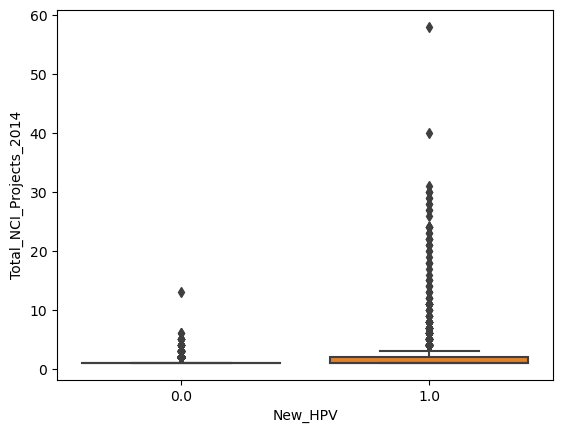

In [145]:
ax = sns.boxplot(x="New_HPV", y="Total_NCI_Projects_2014", data=df_train)

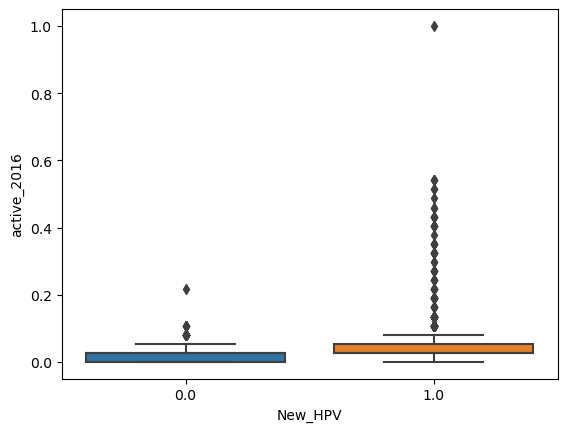

In [146]:
ax = sns.boxplot(x="New_HPV", y="active_2016", data=df_train)

#### Identify the features and lable
We need to identify the **features** and **label** for both the trainig and test datasets

In [147]:
# use conventions typically used in python scikitlearn
X_train = df_train.drop(columns=['New_HPV'])
y_train = df_train['New_HPV']
X_test = df_test.drop(columns=['New_HPV'])
y_test = df_test['New_HPV']

# Model Selection

## Model Evaluation 

In this phase, you take the predictors from your test set and apply your model to them, then assess the quality of the model by comparing the *predicted values* to the *actual values* for each record in your testing data set. 

- **Performance Estimation**: How well will our model do once it is deployed and applied to new data?

Now let's use the model we just fit to make predictions on our test dataset, and see what our accuracy score is:

We will start with the simplest [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model and see how well that does.

You can use any number of metrics to judge your models, but we'll use [`accuracy_score()`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) (ratio of correct predictions to total number of predictions) as our measure.

In [148]:
from sklearn import linear_model

model = linear_model.LogisticRegression(max_iter = 100, intercept_scaling = 2, solver = "lbfgs")

model.fit( X_train, y_train)

print(model)
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

LogisticRegression(intercept_scaling=2)


# Model Evaluation 

Machine learning models usually do not produce a prediction (0 or 1) directly. Rather, models produce a score between 0 and 1 (that can sometimes be interpreted as a probability), which lets you more finely rank all of the examples from *most likely* to *least likely* to have label 1 (positive). This score is then turned into a 0 or 1 based on a user-specified threshold. For example, you might label all examples that have a score greater than 0.5 (1/2) as positive (1), but there's no reason that has to be the cutoff. 

In [149]:
#  from our "predictors" using the model.
y_scores = model.predict_proba(X_test)[:,1]

In [150]:
y_scores

array([0.48603122, 0.44795924, 0.48592788, ..., 0.44963829, 0.43665631,
       0.44259546])

<AxesSubplot:>

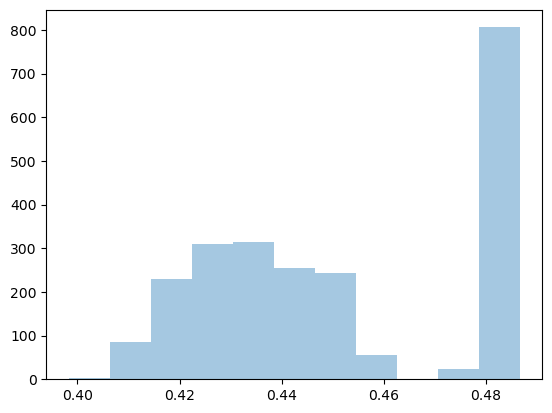

In [151]:
sns.distplot(y_scores, kde=False, rug=False)

In [152]:
calc_threshold = lambda x,y: 0 if x < y else 1 
predicted = np.array( [calc_threshold(score,0.45) for score in y_scores] )
expected = y_test

<AxesSubplot:xlabel='New_HPV'>

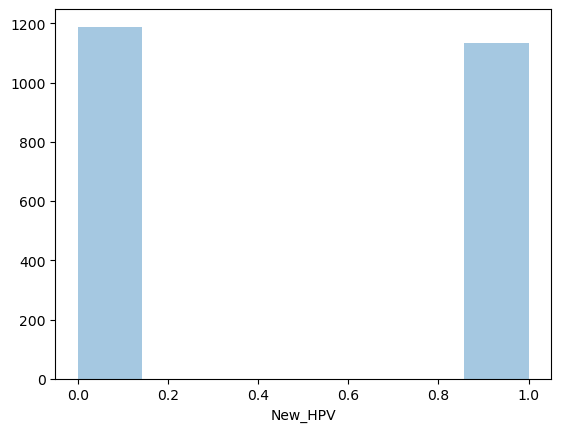

In [153]:
sns.distplot(expected, kde=False, rug=False)

## Confusion Matrix

Once we have tuned our scores to 0 or 1 for classification, we create a *confusion matrix*, which  has four cells: true negatives, true positives, false negatives, and false positives. Each data point belongs in one of these cells, because it has both a ground truth and a predicted label. If an example was predicted to be negative and is negative, it's a true negative. If an example was predicted to be positive and is positive, it's a true positive. If an example was predicted to be negative and is positive, it's a false negative. If an example was predicted to be positive and is negative, it's a false negative.
![Screenshot%202023-04-16%20at%204.04.32%20PM.png](attachment:Screenshot%202023-04-16%20at%204.04.32%20PM.png)

In [154]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(expected,predicted)
print(conf_matrix)

[[729 460]
 [560 574]]


#### Accuracy
Accuracy is the ratio of the correct predictions (both positive and negative) to all predictions. 
$$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN} $$

In [155]:
# generate an accuracy score by comparing expected to predicted.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(expected, predicted)
print( "Accuracy = " + str( accuracy ) )

Accuracy = 0.5609126130004305


#### Precision and Recall.
Two additional metrics that are often used are **precision** and **recall**. 

Precision measures the accuracy of the classifier when it predicts an example to be positive. It is the ratio of correctly predicted positive examples to examples predicted to be positive. 

$$ Precision = \frac{TP}{TP+FP}$$

Recall measures the accuracy of the classifier to find positive examples in the data. 

$$ Recall = \frac{TP}{TP+FN} $$

By selecting different thresholds we can vary and tune the precision and recall of a given classifier. A conservative classifier (threshold 0.99) will classify a case as 1 only when it is *very sure*, leading to high precision. On the other end of the spectrum, a low threshold (e.g. 0.01) will lead to higher recall. 

In [156]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(expected, predicted)
recall = recall_score(expected, predicted)
print( "Precision = " + str( precision ) )
print( "Recall= " + str(recall))

Precision = 0.5551257253384912
Recall= 0.5061728395061729


In [157]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.573307


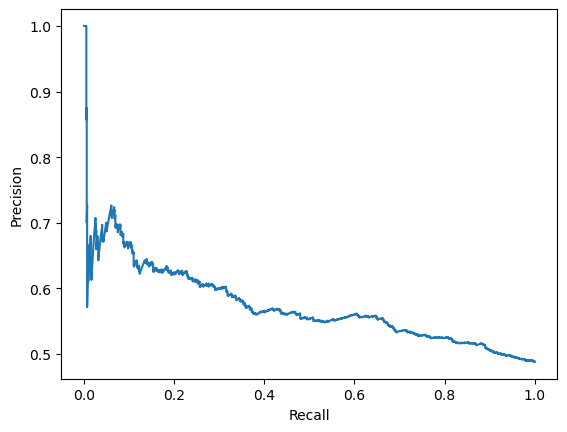

<Figure size 640x480 with 0 Axes>

In [158]:
plot_precision_recall(expected, y_scores)

## Precision and Recall at k%

If we only care about a specific part of the precision-recall curve we can focus on more fine-grained metrics. For instance, say NIH wants to host a workshop for people they think are likley to do brain cancer research in the future, The workshop is expensive so they only want to select the top 1% of people who are likley to do HPV researh in the future. In that case, we would want to prioritize the 1% of applicants who are *most likely* to have future HPV cancer research, and it doesn't matter too much how accurate we are on the ones who aren't very likely to have HPV cancer researh in the future. We can then focus on optimizing our **precision at 1%**.

In [159]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls 
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf()

In [160]:
def precision_at_k(y_true, y_scores,k):
    
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores ])
    return precision_score(y_true, y_pred)

<Figure size 640x480 with 0 Axes>

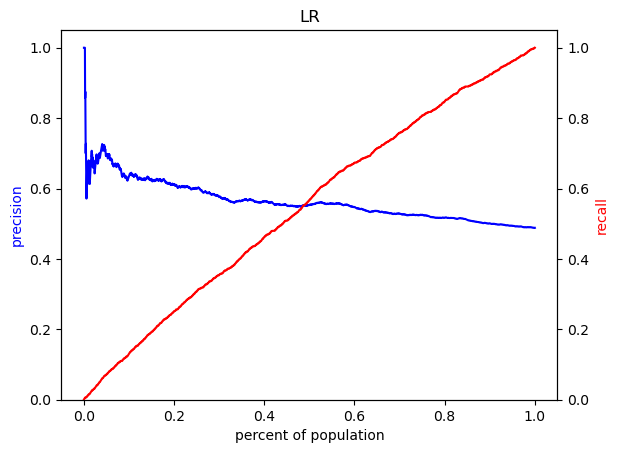

<Figure size 640x480 with 0 Axes>

In [161]:
plot_precision_recall_n(expected,y_scores, 'LR')

In [162]:
p_at_1 = precision_at_k(expected,y_scores, 0.01)
print('Precision at 1%: {:.2f}'.format(p_at_1))

Precision at 1%: 0.67


# Assess Model Against Baselines


It is important to check our model against a reasonable **baseline** to know how well our model is doing. Without any context, .57% accuracy does not sound great... but that really depends on how well you would do by declaring everyone will not no Cancer researcher in the future, which would be stupid (not to mention useless) model. 

A good place to start is checking against a *random* baseline, assigning every example a label (positive or negative) completely at random. 

In [163]:
random_score = [random.uniform(0,1) for i in enumerate(y_test)] 
random_predicted = np.array( [calc_threshold(score,0.5) for score in random_score] )
random_p_at_5 = precision_at_k(expected,random_predicted, 0.01)
print('Precision at 1% (random): {:.2f}'.format(random_p_at_5))

Precision at 1% (random): 0.50


## 6) Adjust the perameters of your model (and/or create more features) until you are able to produse a model that does an ok job (it does not have to be great) at predicting your lable in your test data. Report the accuracy, precesion, and recall.(3 points)

#### Plots and values are few lines above:
#### When I ran the last time before submission, 
#### Accuracy = 0.56
#### Precision = 0.56
#### Recall= 0.51